# <span style="color:orange"> *Multiple bounded optimization* </span> 

In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import subprocess
import sys
import pandas as pd
import os

 # <span style="color:lime"> *Repository & Tool loading* </span>
 Remember to check that it says the exact commit you should be working on </br>
 ### *This only needs to be run once, then the folder will be created*

In [2]:
%cd susceptibility-to-fieldmap-fft 
!git status
!git checkout d9f785b
%pip install .

c:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt\susceptibility-to-fieldmap-fft


c:\Users\Admin\miniconda3\envs\shazam32\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


Note: switching to 'd9f785b'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at d9f785b Fix bug


Processing c:\users\admin\documents\msc_project\image-processing-strategies\chi_opt\susceptibility-to-fieldmap-fft
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for susceptibility-to-fieldmap-fft: filename=susceptibility_to_fieldmap_fft-0.0.0-py3-none-any.whl size=23317 sha256=d98a4f31257d2f86a81d9ea3bd3d1a8c12a71eda7802f8698f6891c27c874750
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\08\54\fd\2f77d3bbe57c3710ceb388683d1f58b0cbc72178fffcb8b4c4
Successfully built susceptibility-to-fieldmap-fft
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'susceptibility-to-fieldmap-fft' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'susceptibility-to-fieldmap-fft'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [5]:
home_path = r"C:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt"
#Once we confirmed the head of the chi to fbfest we can go to home
%cd {home_path}
!ls

C:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt
chi_opt_demod_32.ipynb
chi_opt_demod_33.ipynb
chi_opt_demod_35.ipynb
demod.py
shazam_requirements.txt
susceptibility-to-fieldmap-fft
tissue-to-MRproperty
utils


In [6]:
path_to_chi_to_fm_fft = r"C:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt\susceptibility-to-fieldmap-fft"
sys.path.append(path_to_chi_to_fm_fft)
#sys.path.append('/Users/evaalonsoortiz/Documents/python/susceptibility-to-fieldmap-fft/')
from functions import compute_fieldmap

In [7]:
#Function to automate the subprocess of extractiing measure with SCT through the terminal
from utils.extract_metric import extract_metrics
# This function is only useful if you want to print and display while optimizing
# Example of calling the function:
#extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_metric_mask, out_B0_metrics_path, method='wa', vert="3:15") # Change numbers x:y accordingly

 # <span style="color:silver"> *Data analysis* </span> 

In [33]:
# Define the run nfolder name
run_number = "test2_fixnan"

In [35]:
# Everytime you run the code, it will create a new folder with the run number and restart the counter
path_to_iter_fms = r"E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms"
path_to_iter_metrics = r"E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics"

path_to_iter_fms = os.path.join(path_to_iter_fms,run_number)
path_to_iter_metrics = os.path.join(path_to_iter_metrics,run_number)
counter = 0

#########
# This don't change, this are used with the simulation's FOV
path_to_sim_metric_mask = "E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz"
path_to_dmod_mask = "E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz"
path_to_chimap = "E:/msc_data/ismrm_2025/db0_032/fm/sim/B1_chi_maps/db0_032_sus_opt_map.nii.gz" # -4.2ppm internal air (past value)
path_to_segs = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt2/grouped_wb_segs.nii.gz"


In [11]:
dB0_032_exp_meas = nib.load("E:/msc_data/ismrm_2025/db0_032/fm/C1_meas/exp/tests/test6_pro/B0.nii").get_fdata()
dB0_032_exp_dmod_mask = nib.load("E:/msc_data/ismrm_2025/db0_032/fm/processing_steps/exp/label_vert/cord_mask.nii.gz").get_fdata()
dB0_032_exp_metric_mask = nib.load("E:/msc_data/ismrm_2025/db0_032/fm/processing_steps/exp/label_vert/cord_mask_labeled.nii.gz").get_fdata()

In [12]:
db0_032_dmod_value = np.mean(dB0_032_exp_meas[dB0_032_exp_dmod_mask==1])
print("Demodulation value for dB0_032: ", db0_032_dmod_value)

Demodulation value for dB0_032:  -237.49879980185443


In [41]:
# load it:
db0_032_avg_metric_values_df = pd.read_csv(r"E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\dB0_032_avg_dmod_meas_metrics_c5t8.csv")

In [43]:
# Check the values:
db0_032_avg_metric_values = db0_032_avg_metric_values_df['WA()']
db0_032_avg_metric_values
# This is the one used in the optimization loop!

0    -106.139850
1     -53.375568
2      33.069596
3     101.583283
4      69.157018
5     -10.052884
6     -30.909861
7     -11.544327
8      15.742243
9      26.086530
10     15.495639
Name: WA(), dtype: float64

In [ ]:
central_freq_db0_032 = 123.249521 # in MHz
gamma_bar = 42.58 # MHz/T
# If the central frequency from the scanner is 123.249489 MHz, it meas the B0 strenght we need to simulate is:
B0_used_scanner = central_freq_db0_032 /gamma_bar
print("The B0 to use in the simulation should be: ", B0_used_scanner, "T")

The B0 to use in the simulation should be:  2.894540183184594 T


### <span style="color:chocolate"> *In case you want to compare in a plot!* </span> 

In [16]:
# Load simulation
path_to_zero_ref_metrics = r"E:/msc_data/ismrm_2025/db0_032/fm/sim/D4_metrics/void_ref_ppm_values.csv"
zero_ref_dB0_032_sim = pd.read_csv(path_to_zero_ref_metrics)
zero_ref_dB0_032_sim = zero_ref_dB0_032_sim["WA()"][::-1]
zero_ref_dB0_032_sim

9   -3.177279
8   -2.695261
7   -2.000308
6   -1.712680
5   -1.795637
4   -1.807442
3   -1.644983
2   -1.444780
1   -1.338200
0   -1.431419
Name: WA(), dtype: float64

In [17]:
# Go to Hz using the central frequency from the scanner:
zero_ref_dB0_032_sim_Hz = zero_ref_dB0_032_sim * central_freq_db0_032
zero_ref_dB0_032_sim_Hz

9   -391.598143
8   -332.189663
7   -246.536959
6   -211.086936
5   -221.311394
4   -222.766399
3   -202.743319
2   -178.068501
1   -164.932542
0   -176.421745
Name: WA(), dtype: float64

In [18]:
# Demodulate with SC average and plot
db0_032_sim_dmod_value = zero_ref_dB0_032_sim_Hz.mean()
print("Demodulation for simulation using SC average with value: ", db0_032_sim_dmod_value)

Demodulation for simulation using SC average with value:  -234.7655600157609


In [64]:
# Demodulate and plot:
demod_dB0_032_sim_Hz = zero_ref_dB0_032_sim_Hz - db0_032_sim_dmod_value
demod_dB0_032_sim_Hz


9   -156.832583
8    -97.424103
7    -11.771399
6     23.678624
5     13.454166
4     11.999161
3     32.022241
2     56.697059
1     69.833018
0     58.343815
Name: WA(), dtype: float64

In [66]:
db0_032_avg_metric_values[:-1]

0   -106.139850
1    -53.375568
2     33.069596
3    101.583283
4     69.157018
5    -10.052884
6    -30.909861
7    -11.544327
8     15.742243
9     26.086530
Name: WA(), dtype: float64

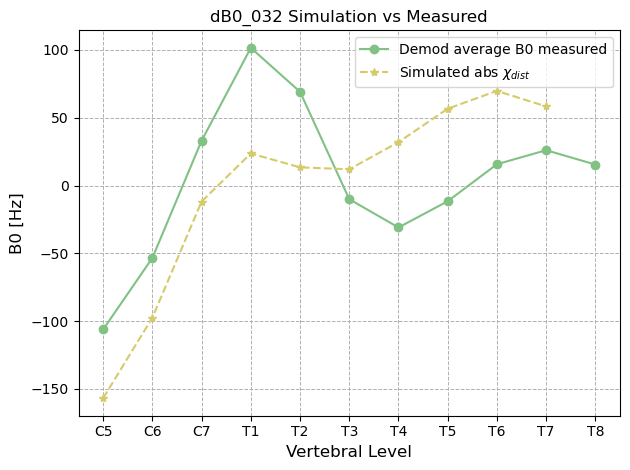

In [62]:
# With that done we can plot them:
vertebrae_levels_sim = ['C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] # From 5 to 14
vertebrae_levels_meas = ['C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8'] # From 5 to 15
plt.plot(vertebrae_levels_meas, db0_032_avg_metric_values, marker = 'o', linestyle = '-', label = "Demod average B0 measured", color = "#81C184")
plt.plot(vertebrae_levels_sim, demod_dB0_032_sim_Hz, marker = '*', linestyle = '--', label = r"Simulated abs $\chi_{dist}$", color = "#D5CB6A")

title = "dB0_032 Simulation vs Measured"
plt.title(title)
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)
plt.legend()
# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

#yticks = range(-450, 450, 100) 
#plt.yticks(yticks)

# Show the plot
plt.show()

In [67]:
difference_l2 = np.linalg.norm(db0_032_avg_metric_values[:-1] - demod_dB0_032_sim_Hz)
print("Difference L2 norm: ", difference_l2)

Difference L2 norm:  317.32917815644123


In [69]:
manual_l2_norm = np.sqrt(np.sum((db0_032_avg_metric_values[:-1] - demod_dB0_032_sim_Hz)**2))
print("Manual L2 norm: ", manual_l2_norm)

Manual L2 norm:  317.32917815644123


 # <span style="color:gold"> *Optimization loop!* </span> </br>
 With the graphs working as we expect them too, lets begin chi optimization

In [21]:
history = [] 
history_chi_trachea = []
history_chi_lungs = []

In [24]:
# Loading dependencies outside obj. function to decrease computational needs

# Load the simulated susceptibility map in ppm
sim_chi_img = nib.load(path_to_chimap)
sim_chi_data = sim_chi_img.get_fdata()

# Load segmentation labels that create the chimaps
ROI_img = nib.load(path_to_segs)
ROI_data = ROI_img.get_fdata()

# Find indices with the labels we want to update
ind_trachea = np.where((ROI_data == 8))
ind_lungs = np.where((ROI_data == 7))
#ind_body = np.where((ROI_data == 2))
#ind_bone = np.where((ROI_data == 3))

dmod_sim_mask = nib.load(path_to_dmod_mask).get_fdata()

vertebrae_levels_opt = ['C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8'] # From 5 to 15

In [26]:
def f_simple_double_opt(x):

    global counter # This works? 
    
    counter += 1  
    print('$$$$$$$$$$$$$$$$$$$$$$$$$')
    print(f"Iteration #{counter}")
    print(f"Chi for trachea: {x[0]}")
    print(f"Chi for lungs: {x[1]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")
    
    # Assign variables 
    # Now we get only 1 value 
    #chi_internal_air = 0.27 # ppm in SI units 
    chi_trachea = x[0]
    chi_lungs = x[1]

    sim_chi_data[ind_trachea] = chi_trachea
    sim_chi_data[ind_lungs] = chi_lungs
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50) #, mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * central_freq_db0_032
    
    chi1_name = str(str(float(f"{chi_trachea:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi_lungs:.3f}"))).replace(".","_")
    #chi_3_name = str(str(float(f"{chi_internal_air:.3f}"))).replace(".","_")

    # Just in case you want to check the chimaps created: ###################################
    #chi_map_name = f"chimap_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz"
    # Load where you want to save them, and dont forget to use the same run number :)
    # And don't forget to actually create the run# folder 
    #path_to_iterchimaps = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/chimaps_extra/run14"
    #chimap_img = nib.Nifti1Image(sim_chi_data, affine = sim_chi_img.affine)
    #chimap_save_dir = os.path.join(path_to_iterchimaps, chi_map_name)
    #nib.save(chimap_img, chimap_save_dir)
    ##########################################################################################
    sim_b0_Hz_name = f"sim_dmod_fm_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz"
    iter_fm_save_dir = os.path.join(path_to_iter_fms, sim_b0_Hz_name)
    # Now before saving the new fieldmap, lets demodulate with the SC mask
    iter_demod_value = np.mean(sim_b0_Hz[dmod_sim_mask==1])
    print(f"For iteration #{counter} using {iter_demod_value}")
    demod_iter_fm_Hz = sim_b0_Hz - iter_demod_value

    sim_b0_Hz_img = nib.Nifti1Image(demod_iter_fm_Hz, affine = sim_chi_img.affine )
    nib.save(sim_b0_Hz_img, iter_fm_save_dir)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_dmod_fm_tr_{chi1_name}_l_{chi2_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics, metrics_name)
    vert = "5:15"
    extract_metrics(iter_fm_save_dir, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method = 'wa', vert = vert)

    metric_values = pd.read_csv(path_to_out_metrics)
    sim_fm_vert_values = metric_values['WA()'][::-1]
    
    # This is a test to see if chi value changes

    #crop_sim_values = dmod_sim_vert_values.iloc[[0,4,7]].values
    #print("### Sim Cropped:")
    #print(crop_sim_values)
    #print(type(crop_sim_values))
    #crop_meas_values = avg_resp_b0meas_values.iloc[[0,4,7]].values


    # Dunno how to have options in the objective fucntion so this if is manual lmao
    #if norm_type == "L2":
    difference_l2 = np.linalg.norm(db0_032_avg_metric_values - sim_fm_vert_values ) # This is the L2 norm
    difference = difference_l2
    print("Difference: ", difference)

    #crop_dif =  np.linalg.norm(crop_sim_values - crop_meas_values)
    #crop_dif = np.sum(np.abs(crop_sim_values)-np.abs(crop_meas_values))
    #print("Minimizing difference - L1 Norm: ", crop_dif)
    #difference = crop_dif
    #elif norm_type == "L1":
    #difference_L1 = np.sum(np.abs(avg_resp_b0meas_values)- np.abs(dmod_sim_vert_values))
    #difference =difference_L1
    #print("Minimizing difference - L1 Norm: ", difference_L1)

    plt.clf() # Clear the plot to only have 1 in the output
    plt.plot(vertebrae_levels_opt, sim_fm_vert_values, marker = 'o', linestyle = '--', label = f"Dmod Simulated", color = "#EC3838")  
    plt.plot(vertebrae_levels_opt, db0_032_avg_metric_values, marker = 'o', linestyle = '-', label = "Dmod In-vivo meas", color = "#264cff") 
    plt.title(f"$\\chi$ of trachea: {chi1_name} & Lung: {chi2_name} with Powell method")
    plt.xlabel('Vertebral Level', fontsize=12)
    plt.ylabel('B0 [Hz]', fontsize=12)
    plt.legend()

    yticks = range(-200, 0, 150) 
    plt.yticks(yticks)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()

# Show the plot
    plt.show()

# Trying to show convergence plot
    error = db0_032_avg_metric_values - sim_fm_vert_values
    loss = np.linalg.norm(error)
    history.append(loss)
    history_chi_trachea.append(chi_trachea)
    history_chi_lungs.append(chi_lungs)

    return difference


 # <span style="color:#1FC7AB"> *Optimization results!* </span> </br>

In [27]:
# Before running please verify your outpaths:
print(path_to_iter_fms)
print(path_to_iter_metrics)

E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test1_powell
E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test1_powell


In [28]:
# Reset counter if neceesary (alone verrsion)
# This should be done when defining new paths but sometimes can be overridden
# Use with care
counter

0

In [ ]:
counter = 0
counter

Creating run folders
Folders created:  E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan
$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #1
Chi for trachea: -2.0
Chi for lungs: -4.2
For iteration #1 using -261.49320712903915
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-2_0_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-2_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-2_0_l_-4_2_Hz.csv

Total runtime; 9.254 seconds.

Difference:  314.16168704933557


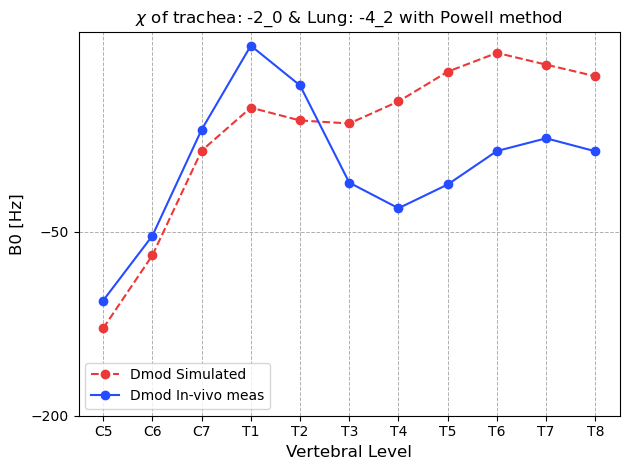

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #2
Chi for trachea: -3.0137767414994534
Chi for lungs: -4.2
For iteration #2 using -261.57649271708755
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-3_014_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-3_014_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-3_014_l_-4_2_Hz.csv

Total runtime; 9.324 seconds.

Difference:  314.05308126788043


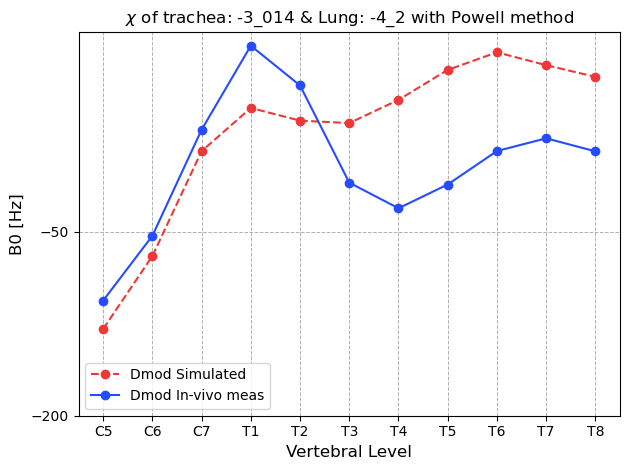

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #3
Chi for trachea: -1.786223258500547
Chi for lungs: -4.2
For iteration #3 using -261.4756445623535
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-1_786_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-1_786_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-1_786_l_-4_2_Hz.csv

Total runtime; 9.368 seconds.

Difference:  314.1867672949122


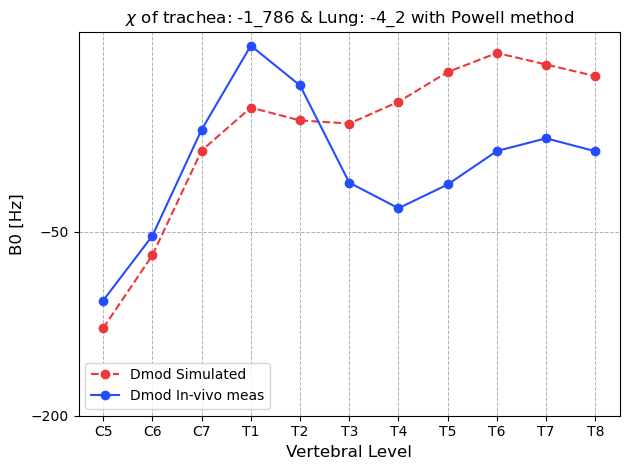

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #4
Chi for trachea: -3.7724465170010935
Chi for lungs: -4.2
For iteration #4 using -261.6388203044158
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-3_772_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-3_772_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-3_772_l_-4_2_Hz.csv

Total runtime; 9.359 seconds.

Difference:  313.9829748409953


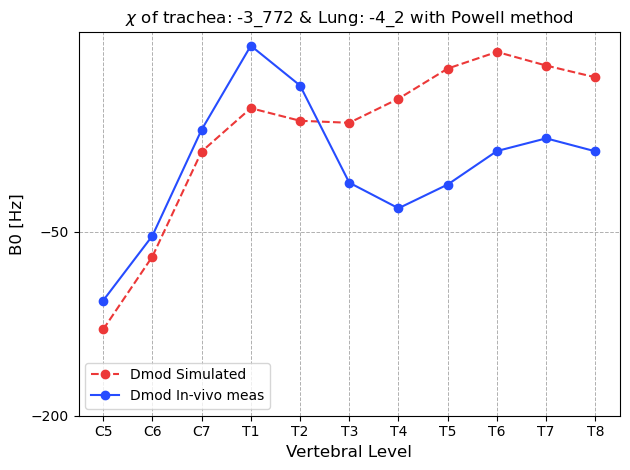

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #5
Chi for trachea: -4.241330224498359
Chi for lungs: -4.2
For iteration #5 using -261.67734087182146
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_241_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_241_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_241_l_-4_2_Hz.csv

Total runtime; 9.304 seconds.

Difference:  313.9444309766685


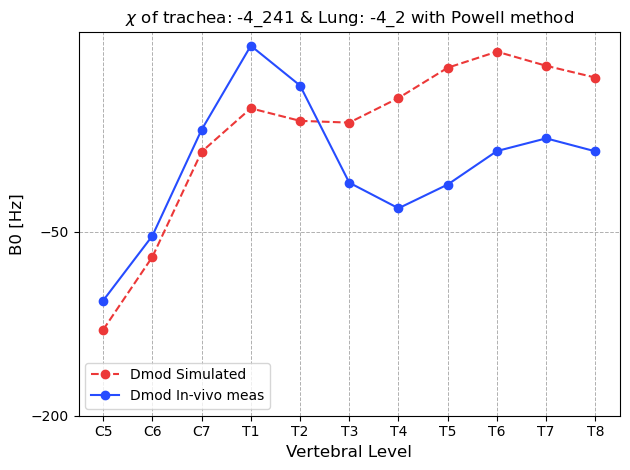

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #6
Chi for trachea: -4.531116292502734
Chi for lungs: -4.2
For iteration #6 using -261.70114789174414
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_531_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_531_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_531_l_-4_2_Hz.csv

Total runtime; 9.316 seconds.

Difference:  313.9224377380529


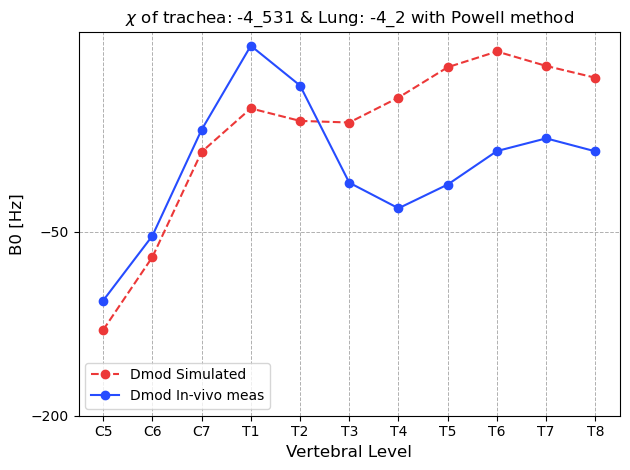

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #7
Chi for trachea: -4.710213931995625
Chi for lungs: -4.2
For iteration #7 using -261.7158614392272
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_71_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_71_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_71_l_-4_2_Hz.csv

Total runtime; 9.214 seconds.

Difference:  313.90954363237097


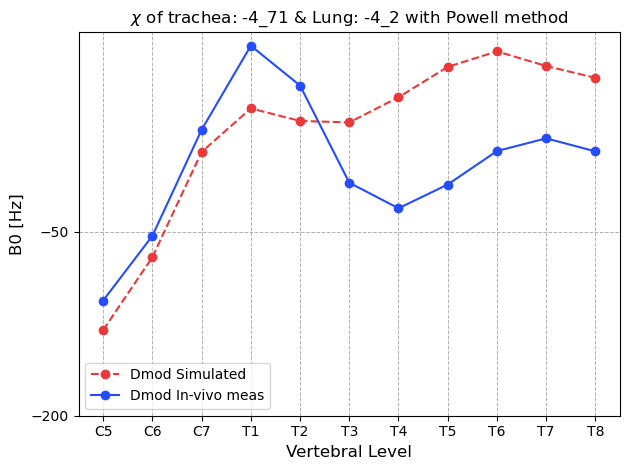

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #8
Chi for trachea: -4.820902360507108
Chi for lungs: -4.2
For iteration #8 using -261.7249549116667
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_821_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_821_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_821_l_-4_2_Hz.csv

Total runtime; 9.372 seconds.

Difference:  313.90184146187823


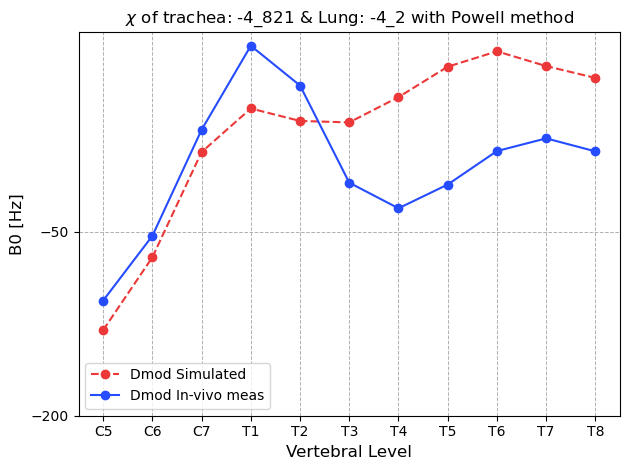

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #9
Chi for trachea: -4.889311571488517
Chi for lungs: -4.2
For iteration #9 using -261.73057498671017
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_889_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_889_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_889_l_-4_2_Hz.csv

Total runtime; 9.377 seconds.

Difference:  313.8971831849818


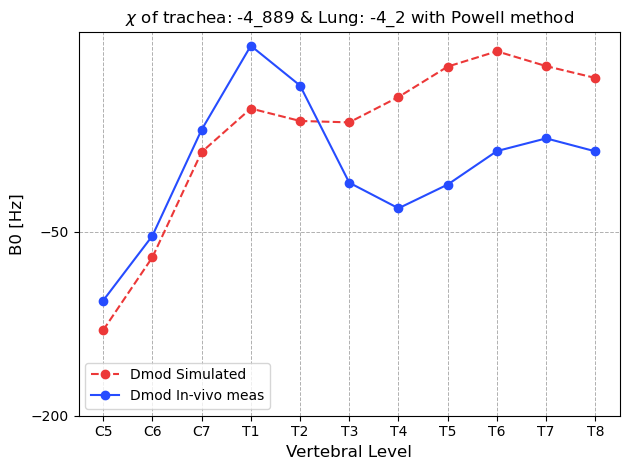

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #10
Chi for trachea: -4.931590789018591
Chi for lungs: -4.2
For iteration #10 using -261.73404838410625
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_932_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_932_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_932_l_-4_2_Hz.csv

Total runtime; 9.356 seconds.

Difference:  313.89434314577335


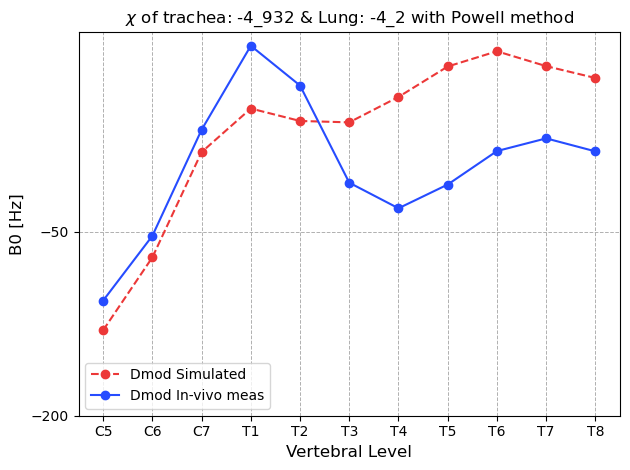

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #11
Chi for trachea: -4.957720782469927
Chi for lungs: -4.2
For iteration #11 using -261.7361950617536
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_958_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_958_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_958_l_-4_2_Hz.csv

Total runtime; 9.362 seconds.

Difference:  313.8926027770072


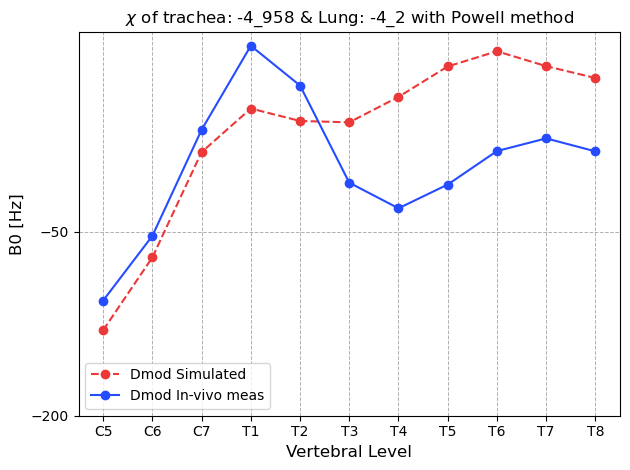

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #12
Chi for trachea: -4.9738700065486645
Chi for lungs: -4.2
For iteration #12 using -261.7375217815025
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_974_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_974_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_974_l_-4_2_Hz.csv

Total runtime; 9.367 seconds.

Difference:  313.891532850655


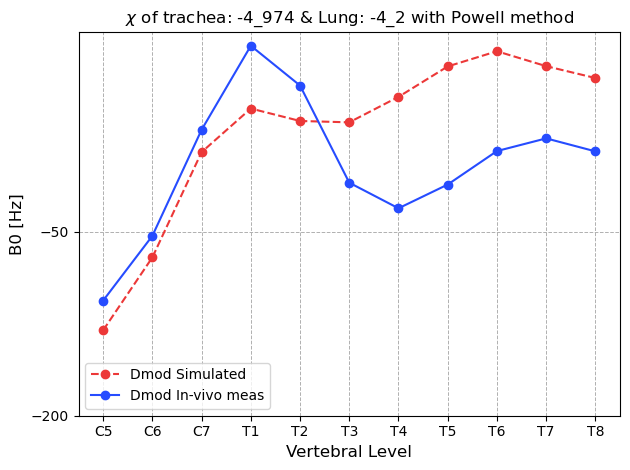

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #13
Chi for trachea: -4.983850775921263
Chi for lungs: -4.2
For iteration #13 using -261.7383417394008
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_984_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_984_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_984_l_-4_2_Hz.csv

Total runtime; 9.377 seconds.

Difference:  313.8908737696615


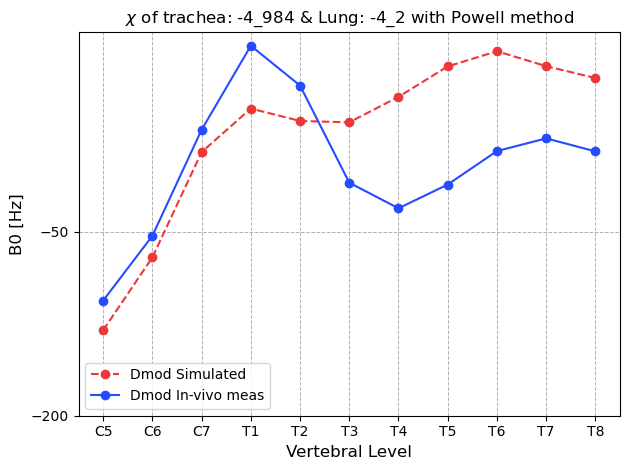

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #14
Chi for trachea: -4.990019230627402
Chi for lungs: -4.2
For iteration #14 using -261.73884850125137
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_99_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_99_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_99_l_-4_2_Hz.csv

Total runtime; 9.492 seconds.

Difference:  313.8904672640237


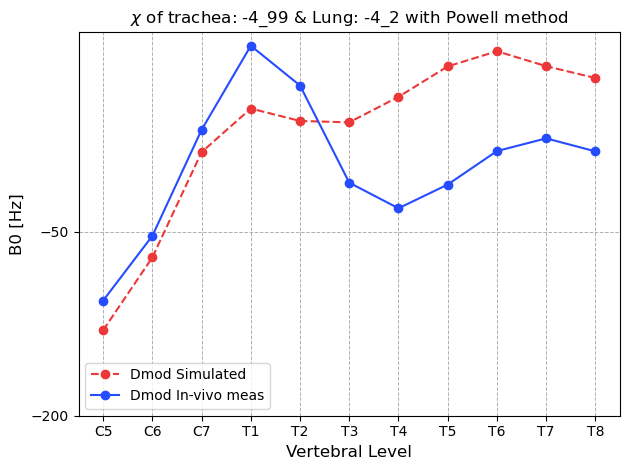

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #15
Chi for trachea: -4.99383154529386
Chi for lungs: -4.2
For iteration #15 using -261.7391616972992
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_994_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_994_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_994_l_-4_2_Hz.csv

Total runtime; 11.095 seconds.

Difference:  313.8902163463044


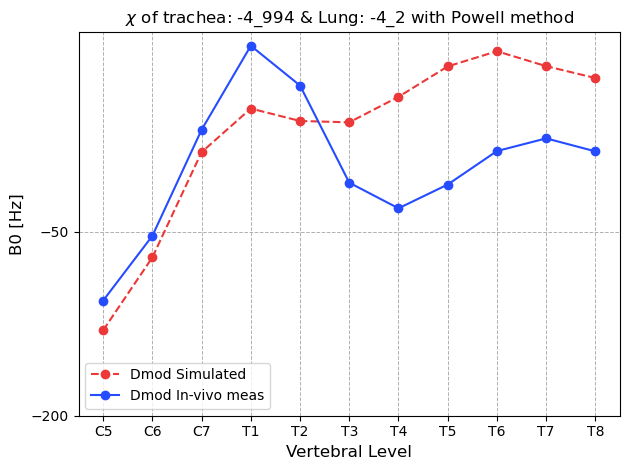

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #16
Chi for trachea: -4.996187685333542
Chi for lungs: -4.2
For iteration #16 using -261.73935526310197
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_996_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_996_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_996_l_-4_2_Hz.csv

Total runtime; 11.347 seconds.

Difference:  313.8900613915492


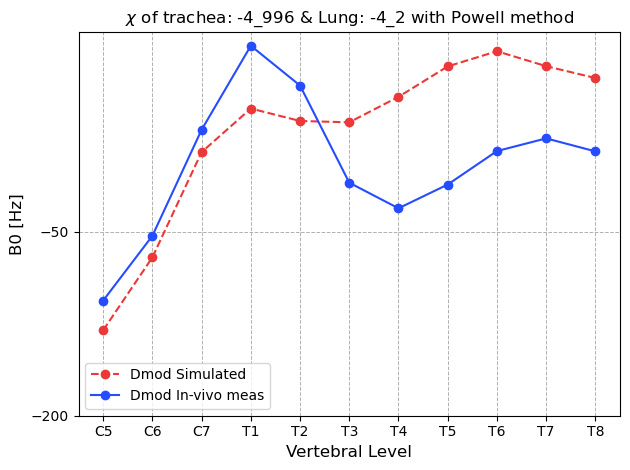

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #17
Chi for trachea: -4.997643859960319
Chi for lungs: -4.2
For iteration #17 using -261.73947489334705
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_998_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_998_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_998_l_-4_2_Hz.csv

Total runtime; 11.153 seconds.

Difference:  313.8899656704324


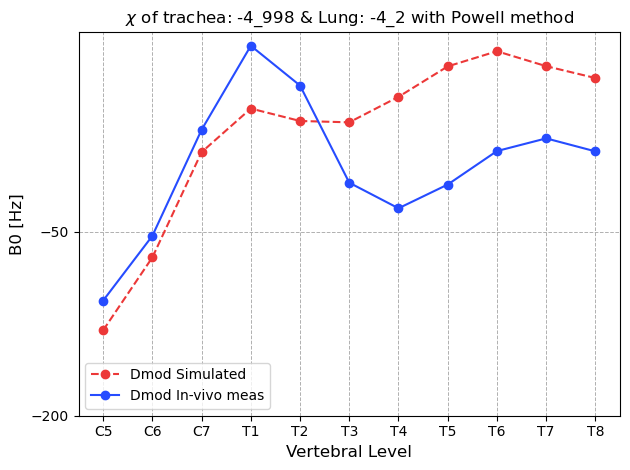

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #18
Chi for trachea: -4.998543825373223
Chi for lungs: -4.2
For iteration #18 using -261.73954882890473
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_999_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_-4_2_Hz.csv

Total runtime; 11.611 seconds.

Difference:  313.8899065291715


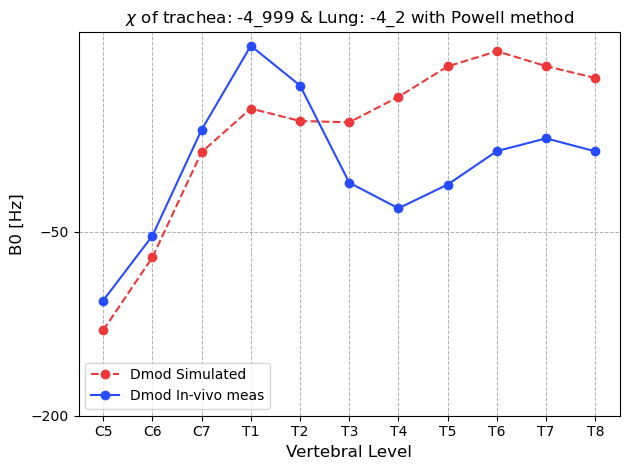

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #19
Chi for trachea: -4.999100034587096
Chi for lungs: -4.2
For iteration #19 using -261.73959452359225
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_999_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_-4_2_Hz.csv

Total runtime; 11.353 seconds.

Difference:  313.8898699846009


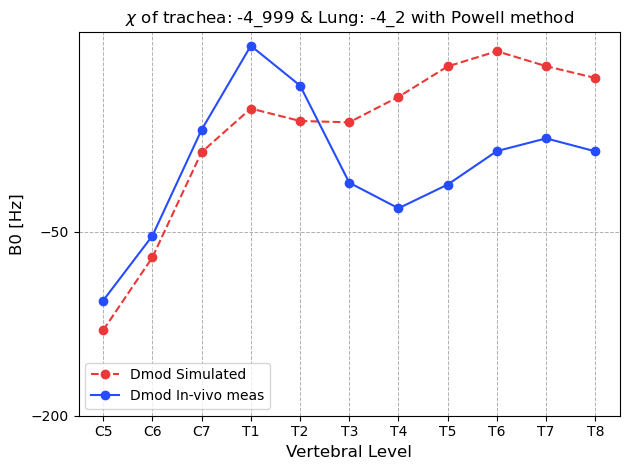

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #20
Chi for trachea: -4.999443790786126
Chi for lungs: -4.2
For iteration #20 using -261.7396227644622
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_999_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_-4_2_Hz.csv

Total runtime; 11.212 seconds.

Difference:  313.8898474013881


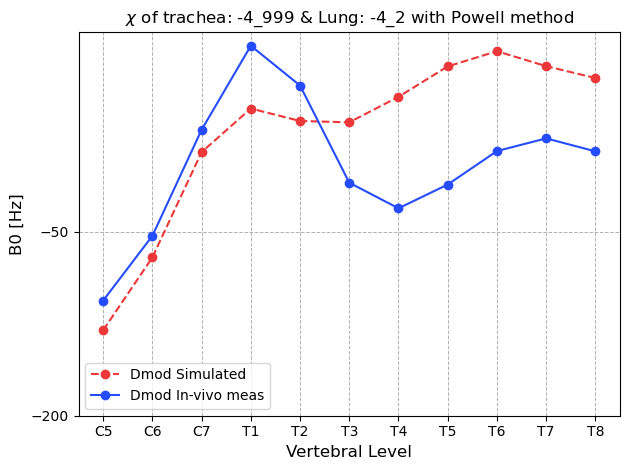

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #21
Chi for trachea: -4.99965624380097
Chi for lungs: -4.2
For iteration #21 using -261.73964021827976
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-4_2_Hz.csv

Total runtime; 10.954 seconds.

Difference:  313.8898334451784


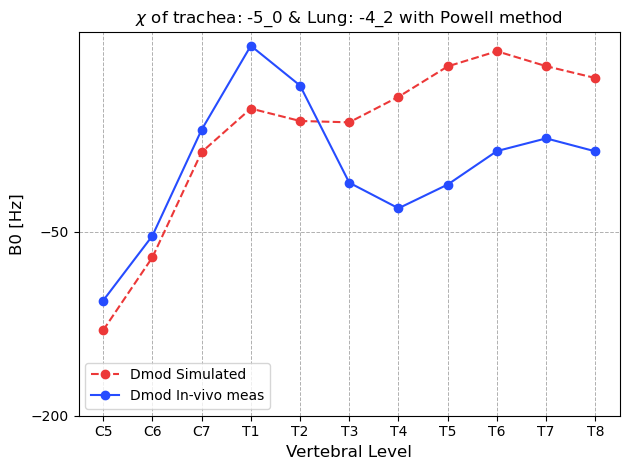

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #22
Chi for trachea: -4.999787546985155
Chi for lungs: -4.2
For iteration #22 using -261.73965100533223
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-4_2_Hz.csv

Total runtime; 11.279 seconds.

Difference:  313.8898248201419


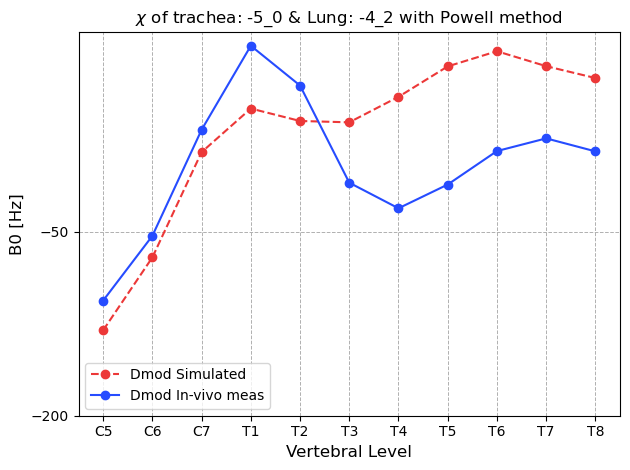

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #23
Chi for trachea: -4.999868696815813
Chi for lungs: -4.2
For iteration #23 using -261.7396576720973
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-4_2_Hz.csv

Total runtime; 10.991 seconds.

Difference:  313.8898194897196


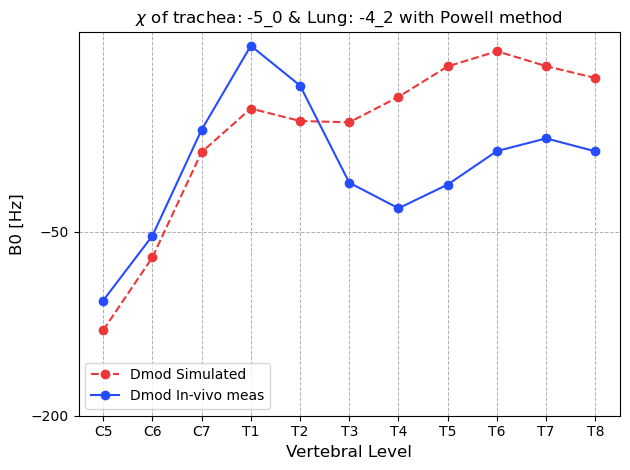

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #24
Chi for trachea: -4.999918850169342
Chi for lungs: -4.2
For iteration #24 using -261.73966179238477
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-4_2_Hz.csv

Total runtime; 11.062 seconds.

Difference:  313.8898161953923


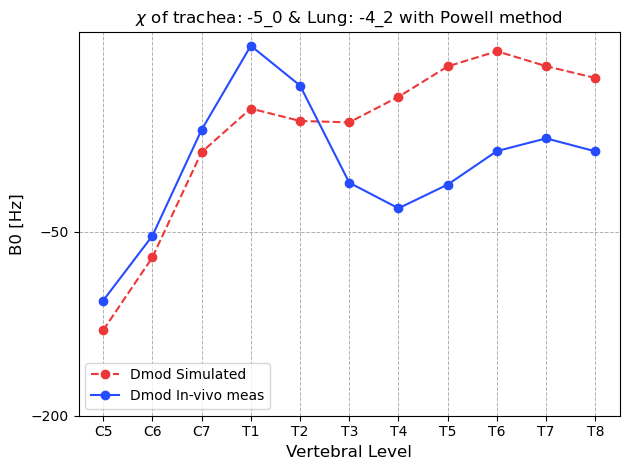

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #25
Chi for trachea: -4.999952227998662
Chi for lungs: -4.2
For iteration #25 using -261.73966453449947
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_-4_2_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-4_2_Hz.csv

Total runtime; 10.633 seconds.

Difference:  313.88981400298997


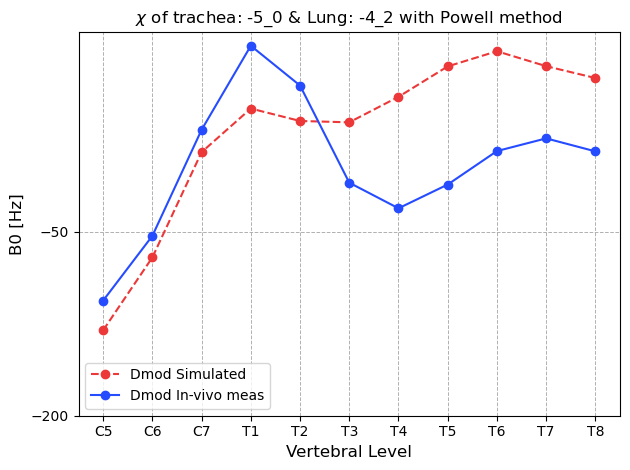

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #26
Chi for trachea: -4.999952227998662
Chi for lungs: -3.0137767414994534
For iteration #26 using -264.70655009946773
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_-3_014_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-3_014_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-3_014_Hz.csv

Total runtime; 11.236 seconds.

Difference:  287.21409326922713


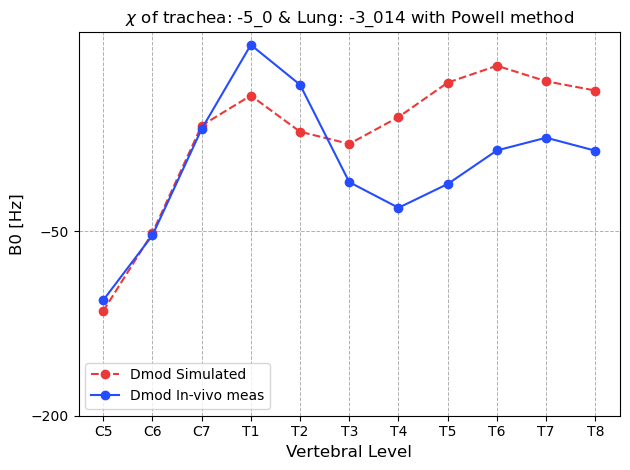

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #27
Chi for trachea: -4.999952227998662
Chi for lungs: -1.7862232585005469
For iteration #27 using -267.7768074754189
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_-1_786_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-1_786_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-1_786_Hz.csv

Total runtime; 11.034 seconds.

Difference:  266.77595918248005


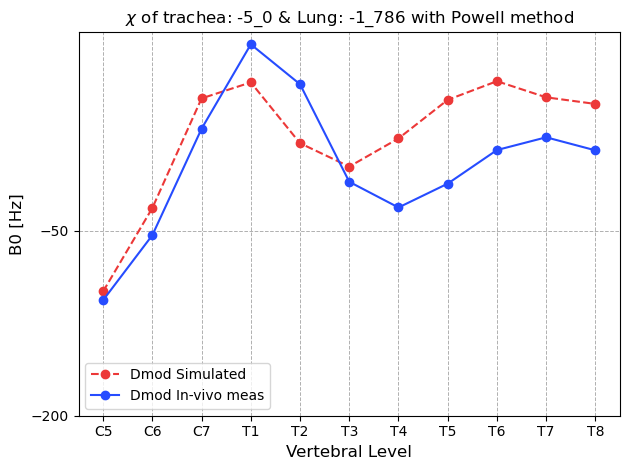

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #28
Chi for trachea: -4.999952227998662
Chi for lungs: -1.0275534829989064
For iteration #28 using -269.67433088796673
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_-1_028_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-1_028_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-1_028_Hz.csv

Total runtime; 11.536 seconds.

Difference:  258.558226413505


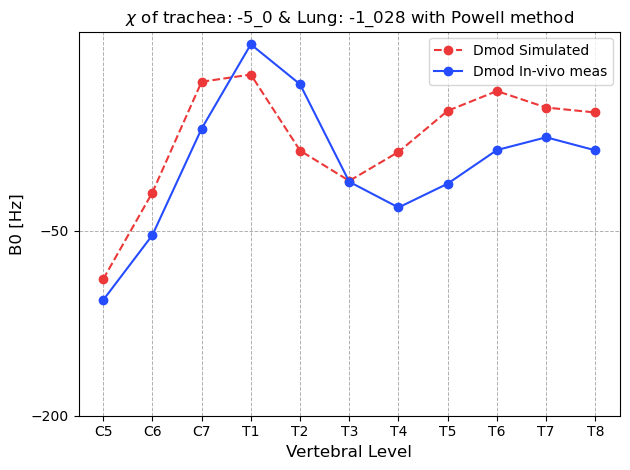

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #29
Chi for trachea: -4.999952227998662
Chi for lungs: -0.5586697755016403
For iteration #29 using -270.84706485137
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_-0_559_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-0_559_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-0_559_Hz.csv

Total runtime; 11.153 seconds.

Difference:  255.35893482175686


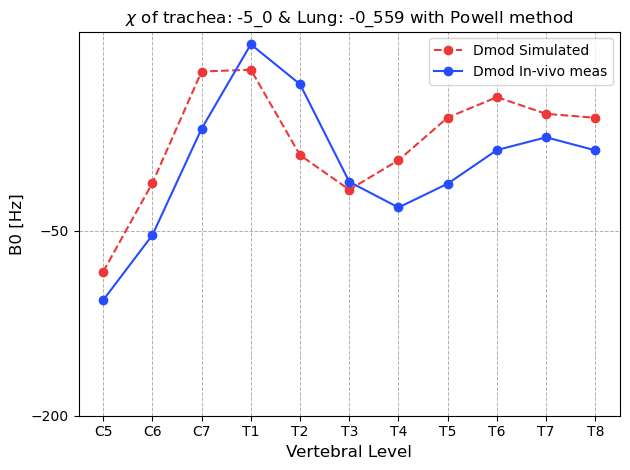

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #30
Chi for trachea: -4.999952227998662
Chi for lungs: -0.26888370749726587
For iteration #30 using -271.57185430051464
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_-0_269_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-0_269_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-0_269_Hz.csv

Total runtime; 14.971 seconds.

Difference:  254.13211801691486


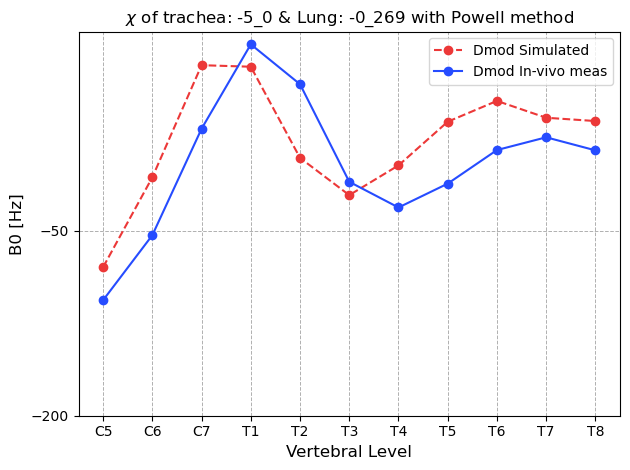

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #31
Chi for trachea: -4.999952227998662
Chi for lungs: -0.08978606800437383
For iteration #31 using -272.01979881477337
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_-0_09_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-0_09_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_-0_09_Hz.csv

Total runtime; 10.886 seconds.

Difference:  253.66556193166508


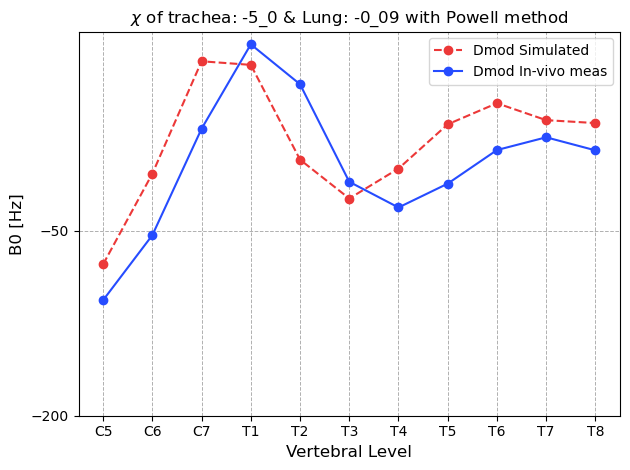

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #32
Chi for trachea: -4.999952227998662
Chi for lungs: 0.02090236050710903
For iteration #32 using -272.2966437496592
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_021_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_021_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_021_Hz.csv

Total runtime; 9.941 seconds.

Difference:  253.48936075844233


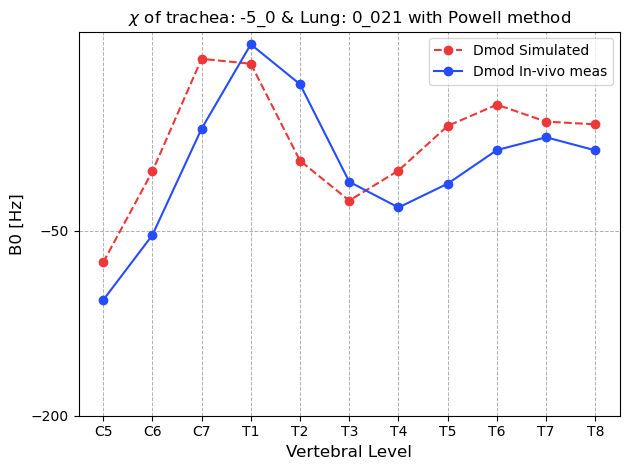

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #33
Chi for trachea: -4.999952227998662
Chi for lungs: 0.0893115714885182
For iteration #33 using -272.467743329032
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_089_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_089_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_089_Hz.csv

Total runtime; 11.082 seconds.

Difference:  253.4234066327552


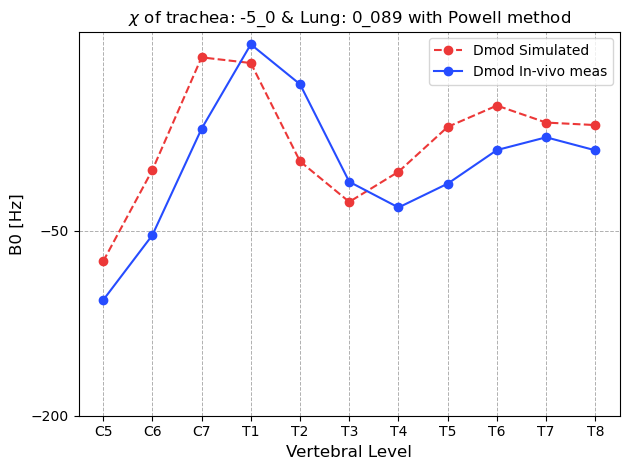

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #34
Chi for trachea: -4.999952227998662
Chi for lungs: 0.131590789018591
For iteration #34 using -272.5734886845451
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_132_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_132_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_132_Hz.csv

Total runtime; 10.898 seconds.

Difference:  253.39906349577856


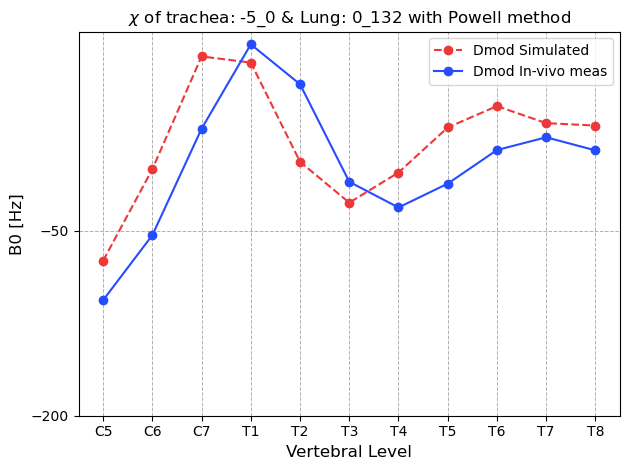

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #35
Chi for trachea: -4.999952227998662
Chi for lungs: 0.1577207824699265
For iteration #35 using -272.6388429084048
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_158_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_158_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_158_Hz.csv

Total runtime; 10.776 seconds.

Difference:  253.3902922167135


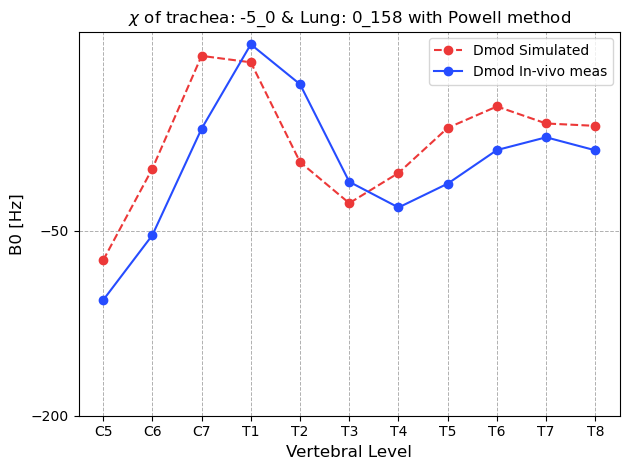

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #36
Chi for trachea: -4.999952227998662
Chi for lungs: 0.1738700065486647
For iteration #36 using -272.67923404005836
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_174_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_174_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_174_Hz.csv

Total runtime; 11.039 seconds.

Difference:  253.38726787786266


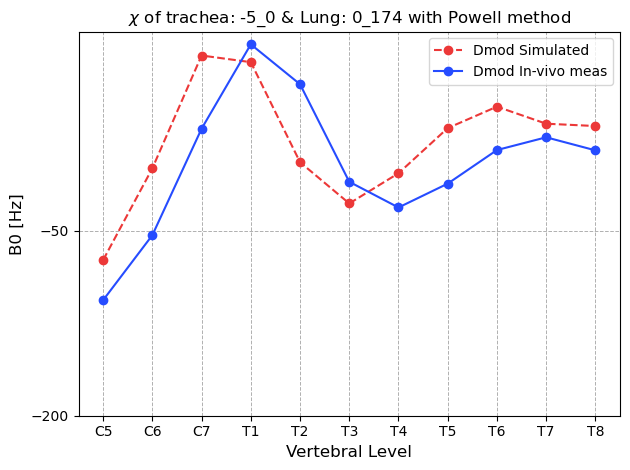

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #37
Chi for trachea: -4.999952227998662
Chi for lungs: 0.19247196980440595
For iteration #37 using -272.7257597643417
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.434 seconds.

Difference:  253.38605337876126


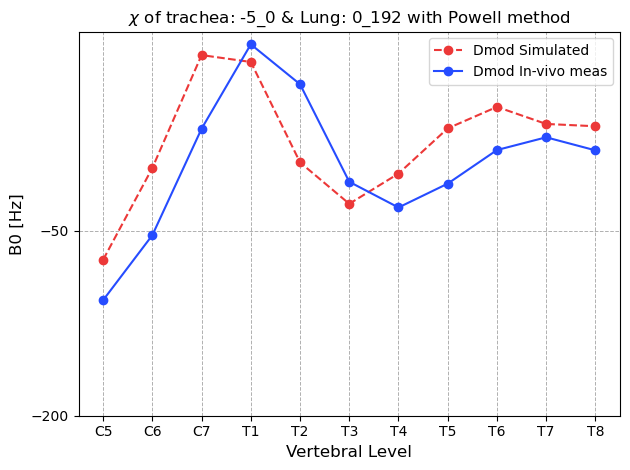

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #38
Chi for trachea: -4.999952227998662
Chi for lungs: 0.19243857132018505
For iteration #38 using -272.72567623075724
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.260 seconds.

Difference:  253.38605338234754


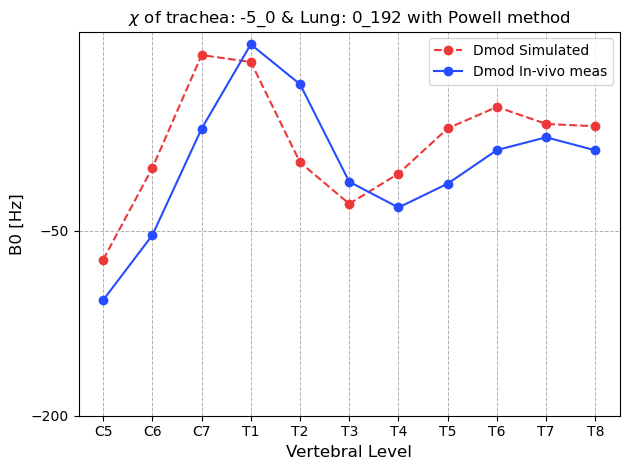

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #39
Chi for trachea: -4.999952227998662
Chi for lungs: 0.19250536828862685
For iteration #39 using -272.72584329792613
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_193_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_193_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_193_Hz.csv

Total runtime; 9.340 seconds.

Difference:  253.38605338300613


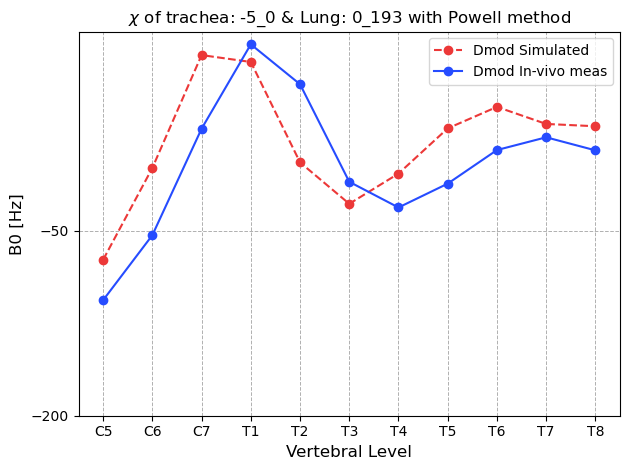

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #40
Chi for trachea: -5.0
Chi for lungs: 0.19254191664384548
For iteration #40 using -272.7259386343632
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_193_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_193_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_193_Hz.csv

Total runtime; 9.173 seconds.

Difference:  253.38599963013812


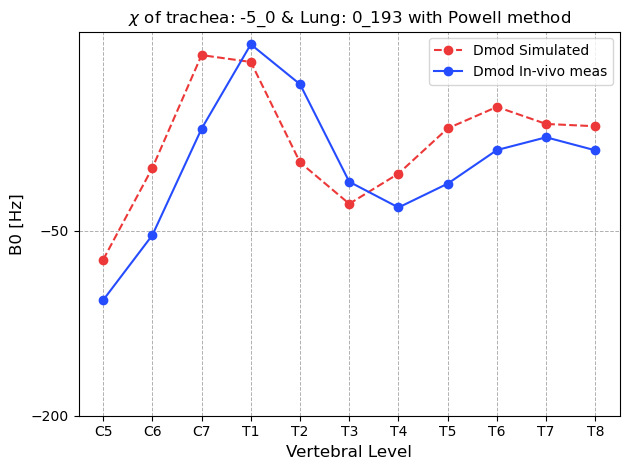

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #41
Chi for trachea: -2.8082162082498177
Chi for lungs: -3.016625475850575
For iteration #41 using -264.51936568421297
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-2_808_l_-3_017_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-2_808_l_-3_017_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-2_808_l_-3_017_Hz.csv

Total runtime; 9.374 seconds.

Difference:  288.01452448993643


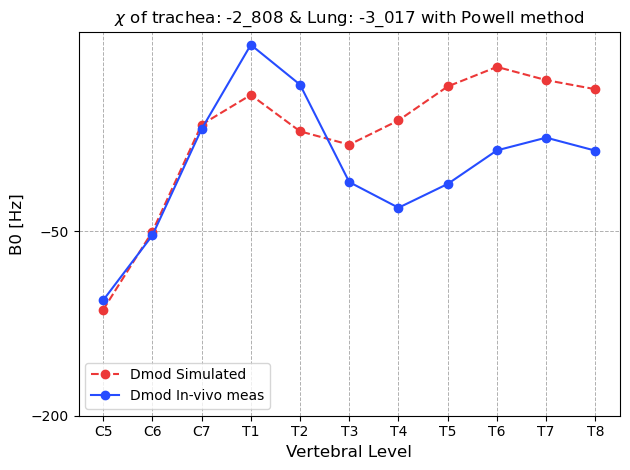

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #42
Chi for trachea: -3.645403120707266
Chi for lungs: -1.7908326075055805
For iteration #42 using -267.6539976200148
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-3_645_l_-1_791_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-3_645_l_-1_791_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-3_645_l_-1_791_Hz.csv

Total runtime; 9.232 seconds.

Difference:  267.69469376054394


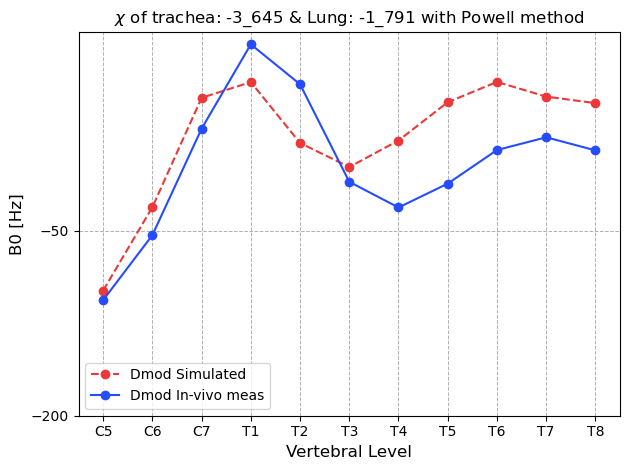

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #43
Chi for trachea: -4.162813087542552
Chi for lungs: -1.0332509517011492
For iteration #43 using -269.5913066985613
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_163_l_-1_033_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_163_l_-1_033_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_163_l_-1_033_Hz.csv

Total runtime; 9.275 seconds.

Difference:  259.2964902887253


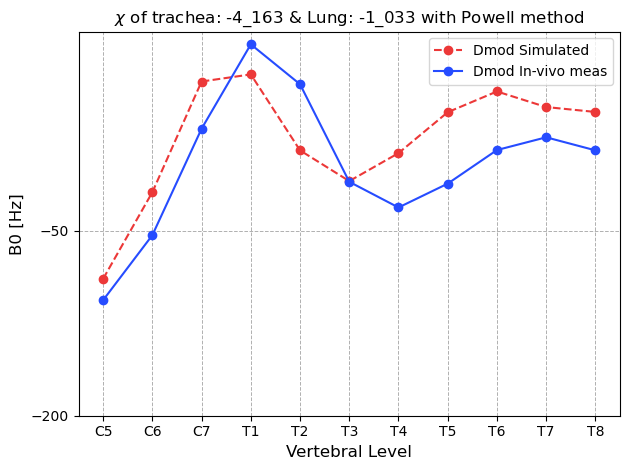

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #44
Chi for trachea: -4.482590033164714
Chi for lungs: -0.5650397391605864
For iteration #44 using -270.7886295558168
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_483_l_-0_565_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_483_l_-0_565_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_483_l_-0_565_Hz.csv

Total runtime; 9.276 seconds.

Difference:  255.87995379036957


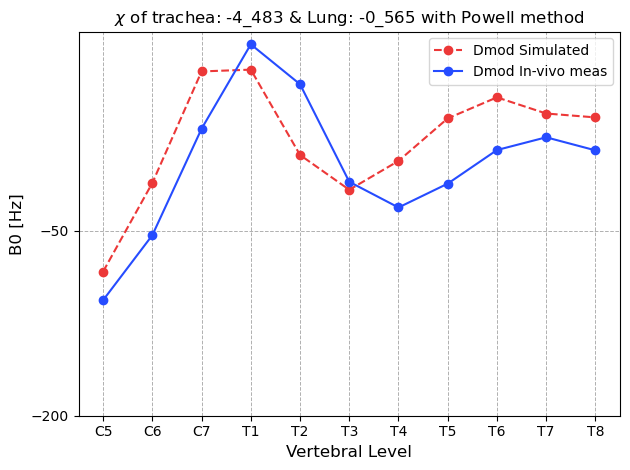

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #45
Chi for trachea: -4.680223054377837
Chi for lungs: -0.2756692958967175
For iteration #45 using -271.52861577710775
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_68_l_-0_276_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_68_l_-0_276_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_68_l_-0_276_Hz.csv

Total runtime; 11.649 seconds.

Difference:  254.47832200419444


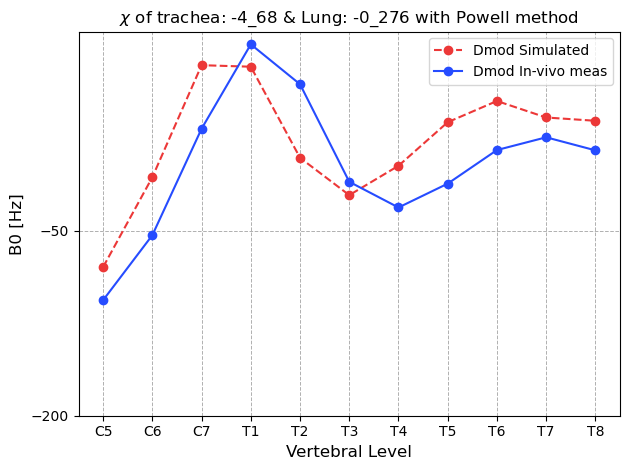

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #46
Chi for trachea: -4.802366978786877
Chi for lungs: -0.09682852662002345
For iteration #46 using -271.9859524130722
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_802_l_-0_097_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_802_l_-0_097_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_802_l_-0_097_Hz.csv

Total runtime; 11.918 seconds.

Difference:  253.8885380441759


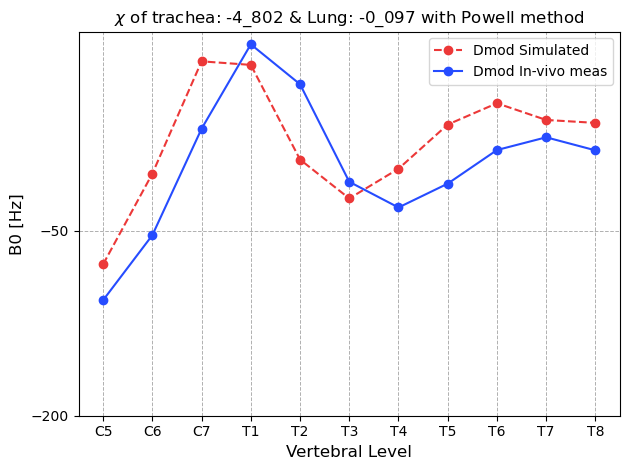

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #47
Chi for trachea: -4.877856075590961
Chi for lungs: 0.013701147367151417
For iteration #47 using -272.26860199839876
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_878_l_0_014_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_878_l_0_014_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_878_l_0_014_Hz.csv

Total runtime; 11.362 seconds.

Difference:  253.6305002776073


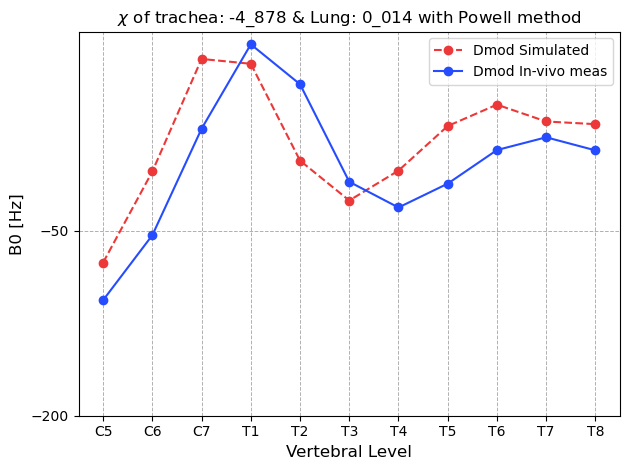

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #48
Chi for trachea: -4.924510903195916
Chi for lungs: 0.0820122426566706
For iteration #48 using -272.4432890490367
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_925_l_0_082_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_925_l_0_082_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_925_l_0_082_Hz.csv

Total runtime; 11.731 seconds.

Difference:  253.5118361254186


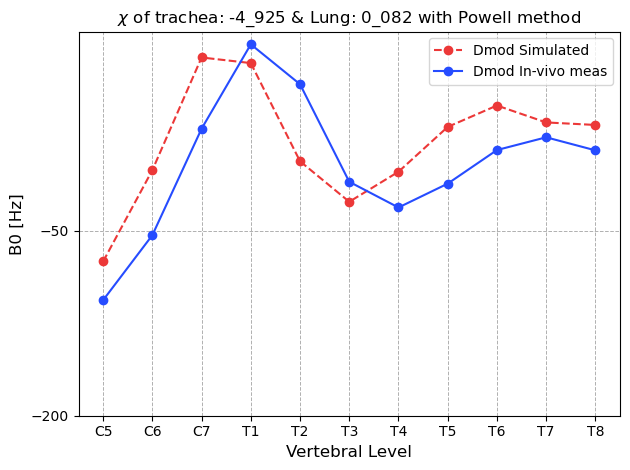

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #49
Chi for trachea: -4.953345172395045
Chi for lungs: 0.12423082135432628
For iteration #49 using -272.55125158372533
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_953_l_0_124_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_953_l_0_124_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_953_l_0_124_Hz.csv

Total runtime; 11.982 seconds.

Difference:  253.45411159663698


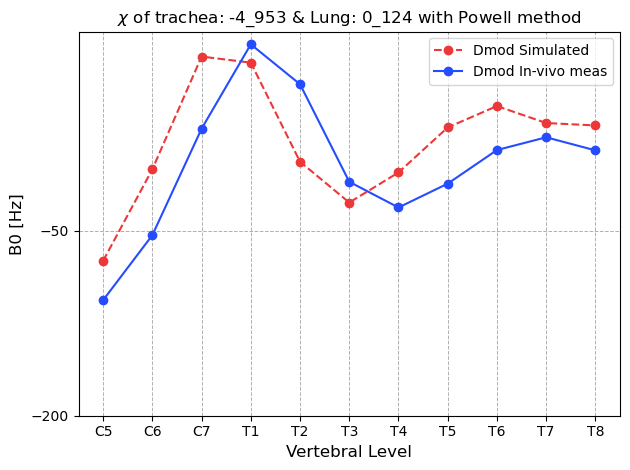

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #50
Chi for trachea: -4.9711657308008705
Chi for lungs: 0.15032333794618977
For iteration #50 using -272.61797609967454
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_971_l_0_15_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_971_l_0_15_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_971_l_0_15_Hz.csv

Total runtime; 9.769 seconds.

Difference:  253.4244044974583


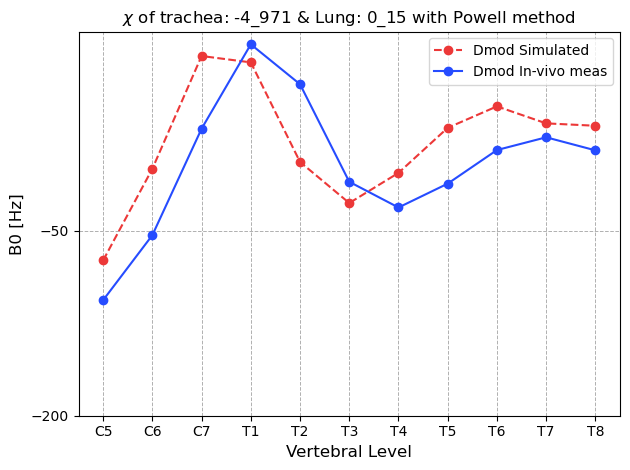

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #51
Chi for trachea: -4.982179441594174
Chi for lungs: 0.16644940005198197
For iteration #51 using -272.659214118414
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_982_l_0_166_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_982_l_0_166_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_982_l_0_166_Hz.csv

Total runtime; 9.734 seconds.

Difference:  253.40832520910777


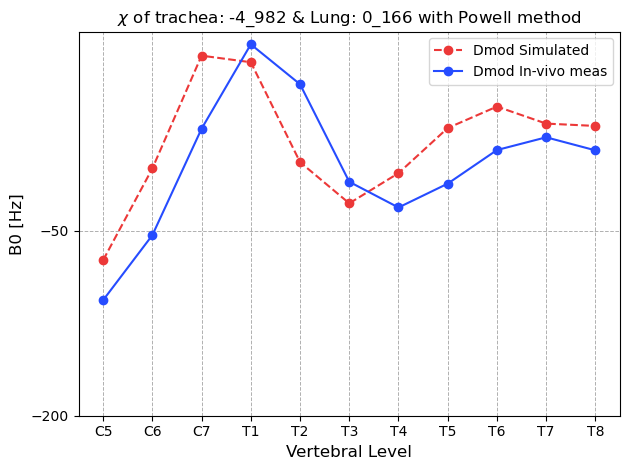

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #52
Chi for trachea: -4.9889862892066965
Chi for lungs: 0.17641585453805325
For iteration #52 using -272.68470061562374
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_989_l_0_176_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_989_l_0_176_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_989_l_0_176_Hz.csv

Total runtime; 9.906 seconds.

Difference:  253.3992589993085


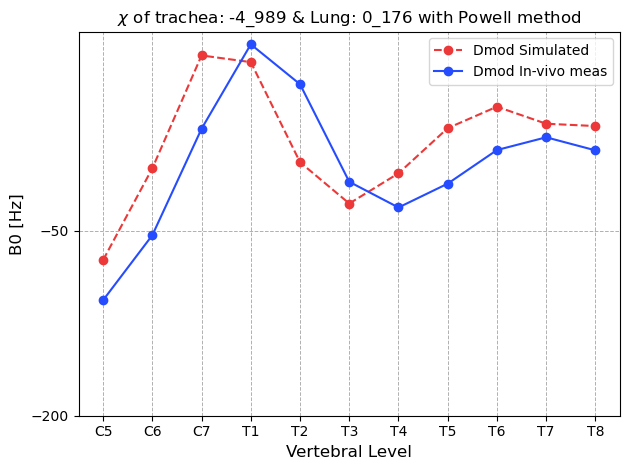

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #53
Chi for trachea: -4.9931931523874775
Chi for lungs: 0.18257546215777418
For iteration #53 using -272.70045213715355
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_993_l_0_183_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_993_l_0_183_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_993_l_0_183_Hz.csv

Total runtime; 9.714 seconds.

Difference:  253.39398863383232


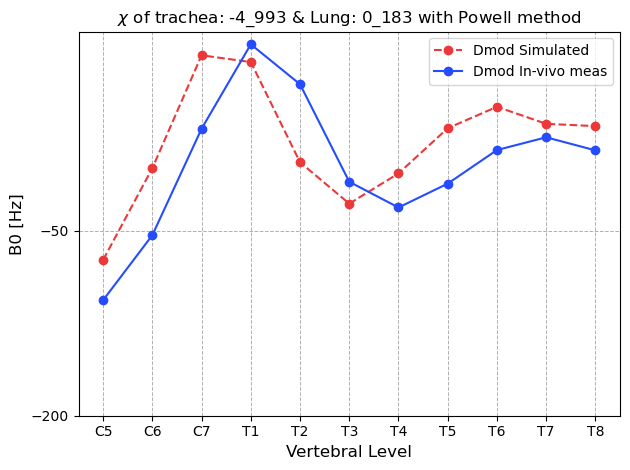

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #54
Chi for trachea: -4.99579313681922
Chi for lungs: 0.18638230902412456
For iteration #54 using -272.7101871128334
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_996_l_0_186_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_996_l_0_186_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_996_l_0_186_Hz.csv

Total runtime; 9.664 seconds.

Difference:  253.39085851882786


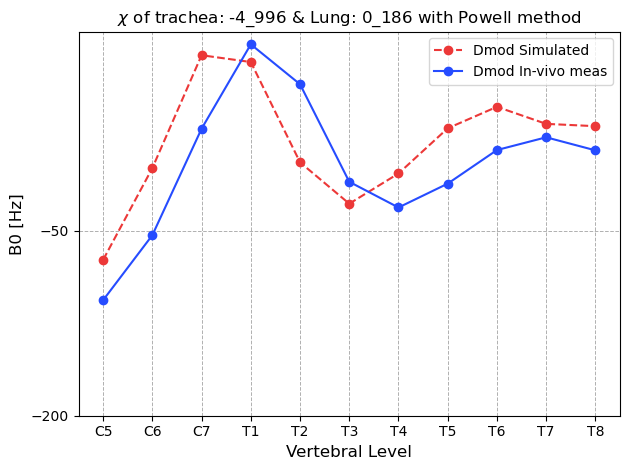

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #55
Chi for trachea: -4.997400015568258
Chi for lungs: 0.1887350697774951
For iteration #55 using -272.71620365868336
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_997_l_0_189_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_997_l_0_189_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_997_l_0_189_Hz.csv

Total runtime; 9.868 seconds.

Difference:  253.38897257029865


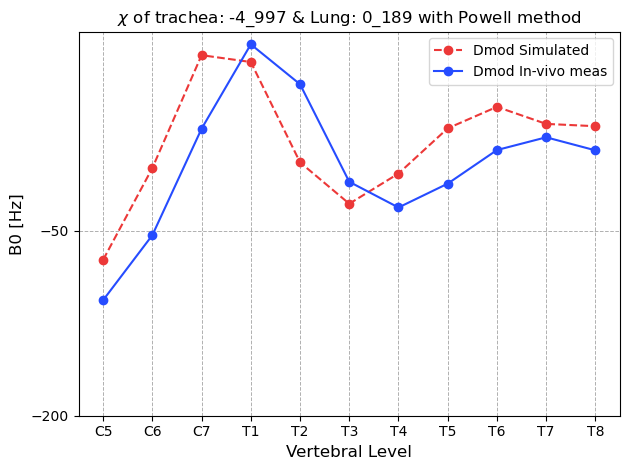

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #56
Chi for trachea: -4.998393121250962
Chi for lungs: 0.19018915589047491
For iteration #56 using -272.7199220885134
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_998_l_0_19_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_998_l_0_19_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_998_l_0_19_Hz.csv

Total runtime; 9.964 seconds.

Difference:  253.38782554213685


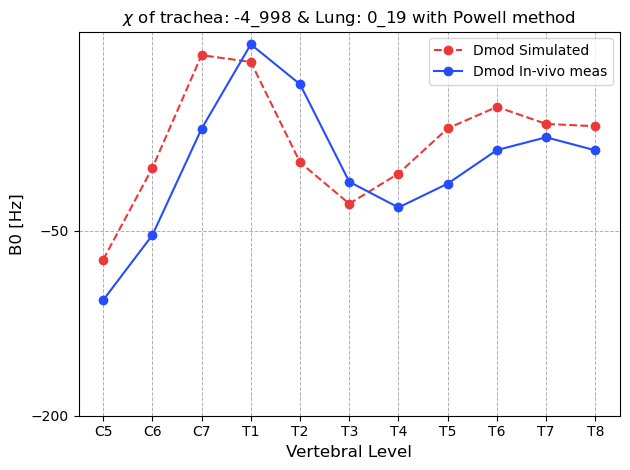

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #57
Chi for trachea: -4.9990068943172945
Chi for lungs: 0.19108783053086567
For iteration #57 using -272.72222020453313
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_999_l_0_191_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_191_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_191_Hz.csv

Total runtime; 9.681 seconds.

Difference:  253.38712372613418


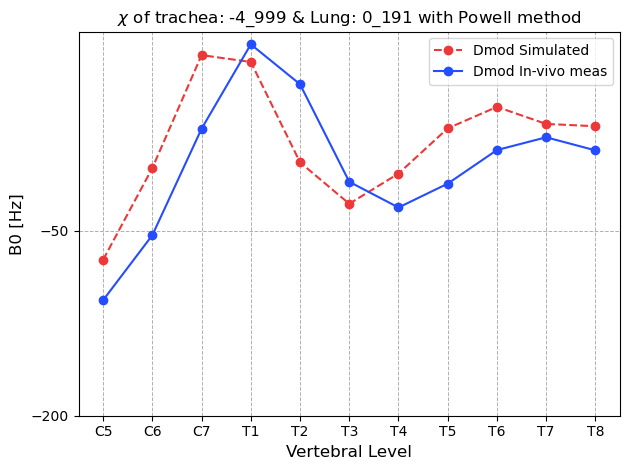

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #58
Chi for trachea: -4.999386226933668
Chi for lungs: 0.19164324200345473
For iteration #58 using -272.7236405183435
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_999_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_192_Hz.csv

Total runtime; 9.790 seconds.

Difference:  253.38669268677415


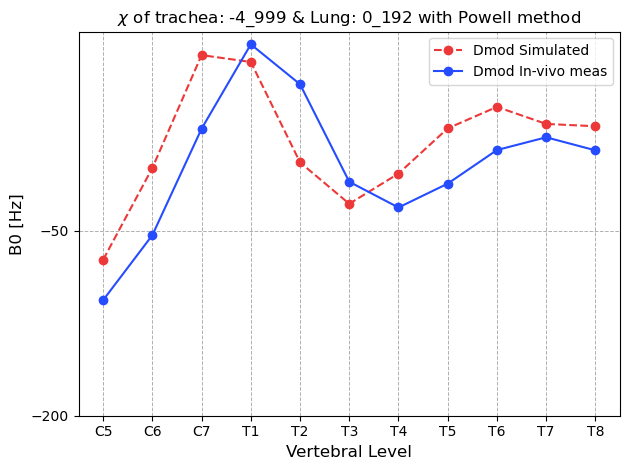

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #59
Chi for trachea: -4.999620667383628
Chi for lungs: 0.1919865051712564
For iteration #59 using -272.7245183205529
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.682 seconds.

Difference:  253.38642732370403


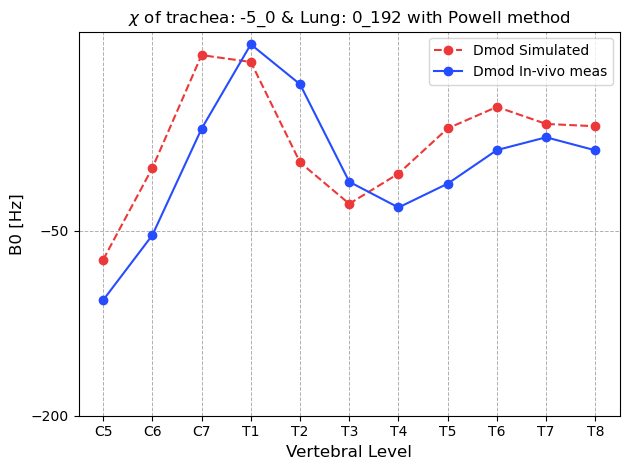

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #60
Chi for trachea: -4.99976555955004
Chi for lungs: 0.1921986534760438
For iteration #60 using -272.72506083215376
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.650 seconds.

Difference:  253.38626371522525


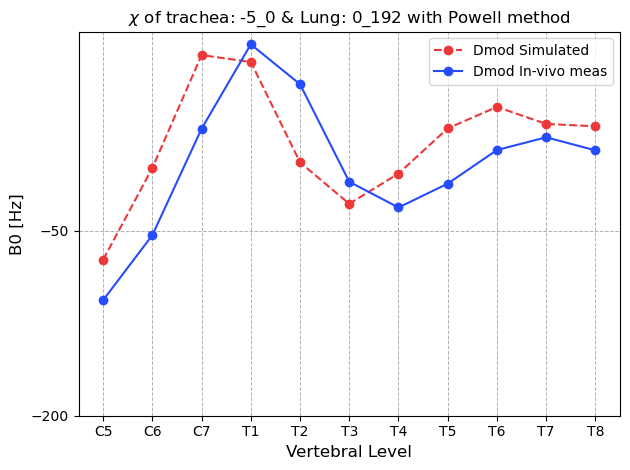

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #61
Chi for trachea: -4.999865557960409
Chi for lungs: 0.19234506921242456
For iteration #61 using -272.7254352505854
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.224 seconds.

Difference:  253.38615097556982


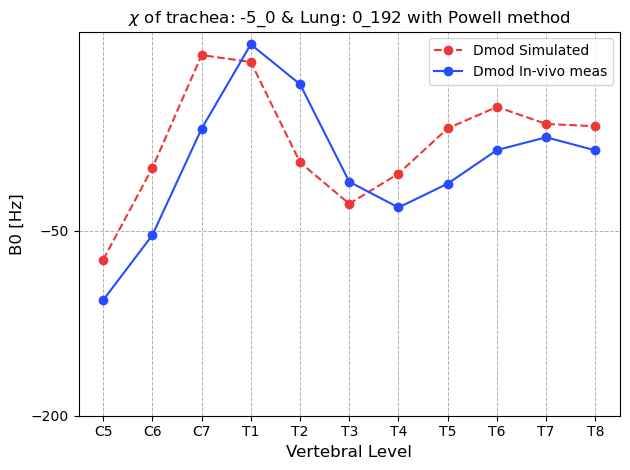

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #62
Chi for trachea: -3.0137767414994534
Chi for lungs: 0.19234506921242456
For iteration #62 using -272.56227055344436
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-3_014_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-3_014_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-3_014_l_0_192_Hz.csv

Total runtime; 9.469 seconds.

Difference:  255.65192657297453


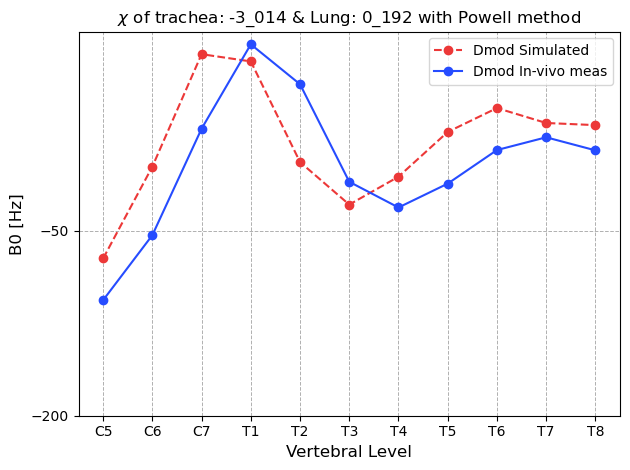

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #63
Chi for trachea: -1.7862232585005469
Chi for lungs: 0.19234506921242456
For iteration #63 using -272.4614223987105
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-1_786_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-1_786_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-1_786_l_0_192_Hz.csv

Total runtime; 9.298 seconds.

Difference:  257.0824724546103


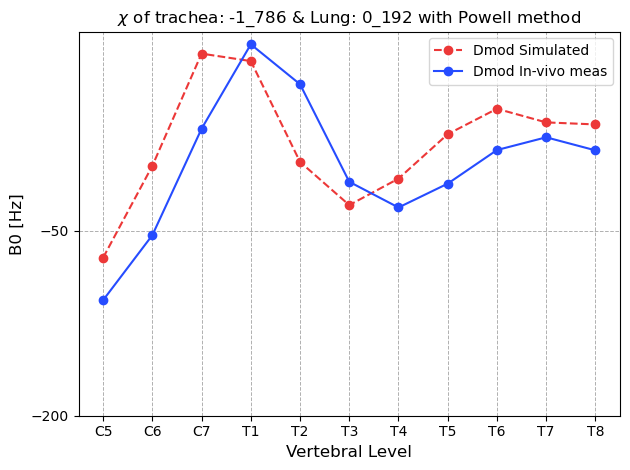

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #64
Chi for trachea: -3.7724465170010935
Chi for lungs: 0.19234506921242456
For iteration #64 using -272.62459814077266
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-3_772_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-3_772_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-3_772_l_0_192_Hz.csv

Total runtime; 9.300 seconds.

Difference:  254.77924394900208


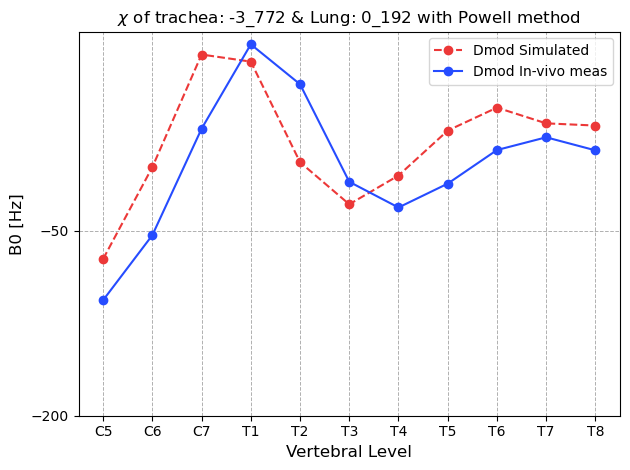

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #65
Chi for trachea: -4.241330224498359
Chi for lungs: 0.19234506921242456
For iteration #65 using -272.6631187081783
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_241_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_241_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_241_l_0_192_Hz.csv

Total runtime; 9.302 seconds.

Difference:  254.2443160709074


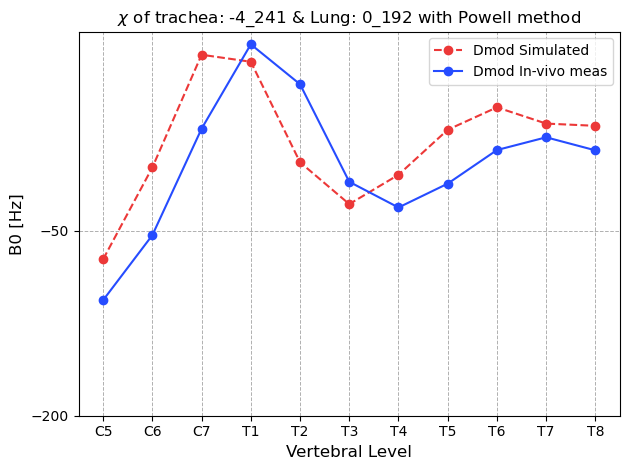

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #66
Chi for trachea: -4.531116292502734
Chi for lungs: 0.19234506921242456
For iteration #66 using -272.6869257281009
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_531_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_531_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_531_l_0_192_Hz.csv

Total runtime; 9.304 seconds.

Difference:  253.91541214196891


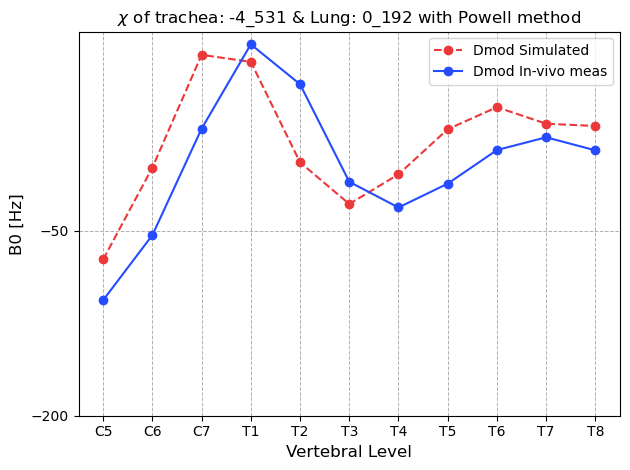

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #67
Chi for trachea: -4.710213931995626
Chi for lungs: 0.19234506921242456
For iteration #67 using -272.70163927558394
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_71_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_71_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_71_l_0_192_Hz.csv

Total runtime; 9.452 seconds.

Difference:  253.71279028156601


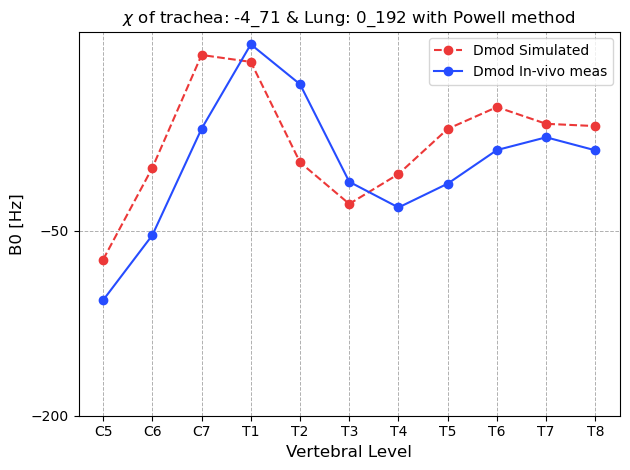

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #68
Chi for trachea: -4.820902360507108
Chi for lungs: 0.19234506921242456
For iteration #68 using -272.7107327480235
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_821_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_821_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_821_l_0_192_Hz.csv

Total runtime; 9.257 seconds.

Difference:  253.58781275074602


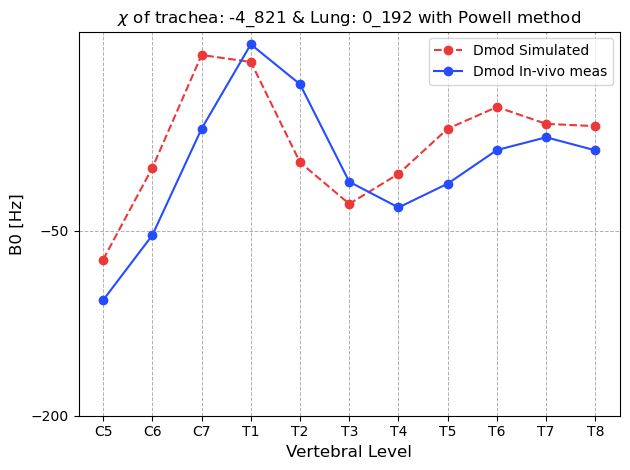

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #69
Chi for trachea: -4.889311571488517
Chi for lungs: 0.19234506921242456
For iteration #69 using -272.7163528230669
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_889_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_889_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_889_l_0_192_Hz.csv

Total runtime; 9.327 seconds.

Difference:  253.51066790490444


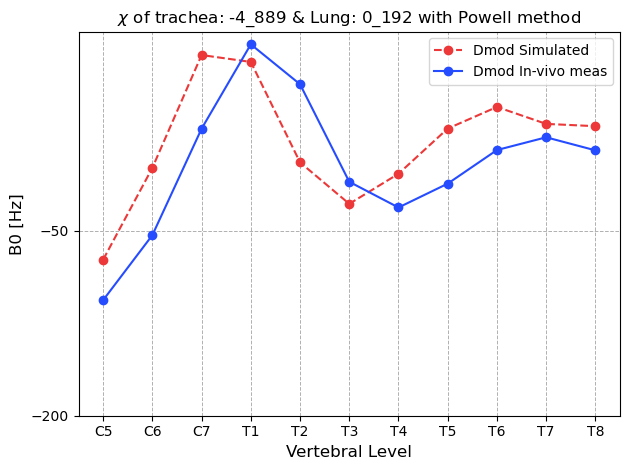

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #70
Chi for trachea: -4.931590789018591
Chi for lungs: 0.19234506921242456
For iteration #70 using -272.7198262204632
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_932_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_932_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_932_l_0_192_Hz.csv

Total runtime; 9.282 seconds.

Difference:  253.4630262879394


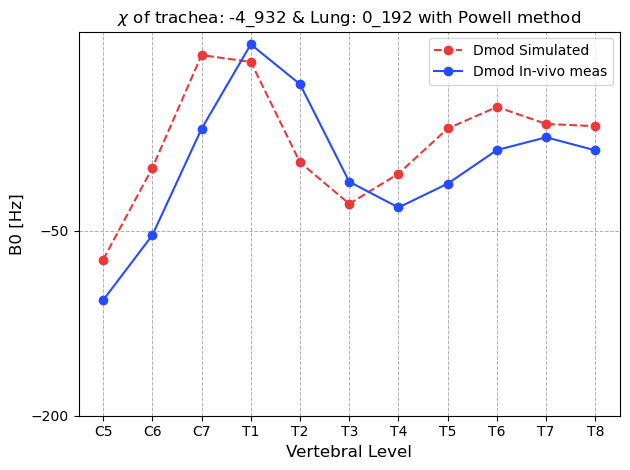

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #71
Chi for trachea: -4.957720782469926
Chi for lungs: 0.19234506921242456
For iteration #71 using -272.72197289811044
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_958_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_958_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_958_l_0_192_Hz.csv

Total runtime; 9.406 seconds.

Difference:  253.43359610719375


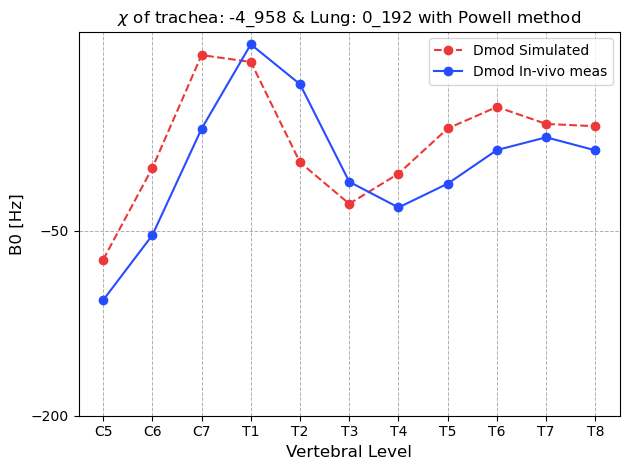

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #72
Chi for trachea: -4.9738700065486645
Chi for lungs: 0.19234506921242456
For iteration #72 using -272.7232996178593
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_974_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_974_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_974_l_0_192_Hz.csv

Total runtime; 9.428 seconds.

Difference:  253.4154125886137


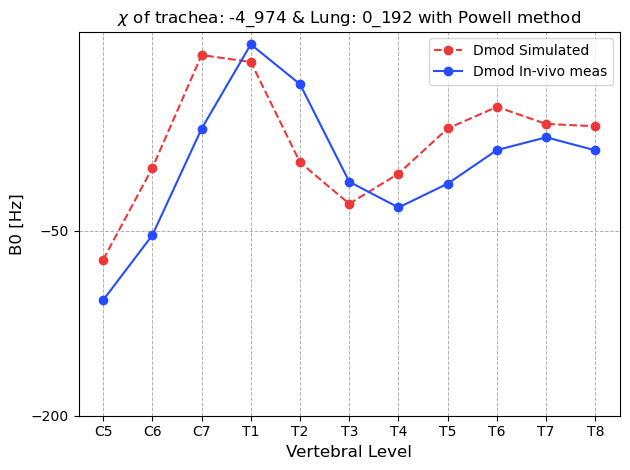

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #73
Chi for trachea: -4.983850775921263
Chi for lungs: 0.19234506921242456
For iteration #73 using -272.7241195757577
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_984_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_984_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_984_l_0_192_Hz.csv

Total runtime; 9.432 seconds.

Difference:  253.40417659375277


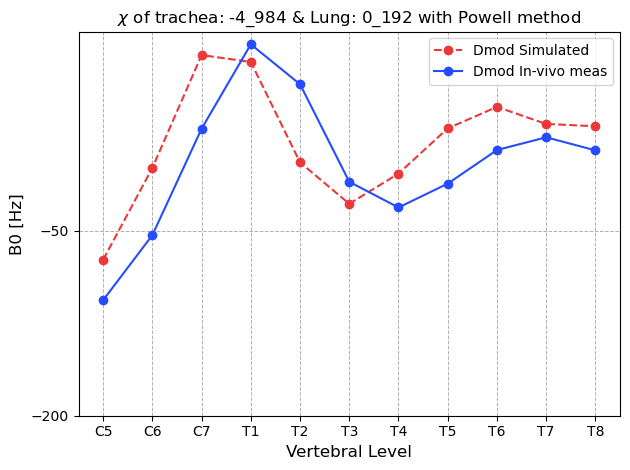

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #74
Chi for trachea: -4.990019230627402
Chi for lungs: 0.19234506921242456
For iteration #74 using -272.7246263376083
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_99_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_99_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_99_l_0_192_Hz.csv

Total runtime; 9.230 seconds.

Difference:  253.39723314545864


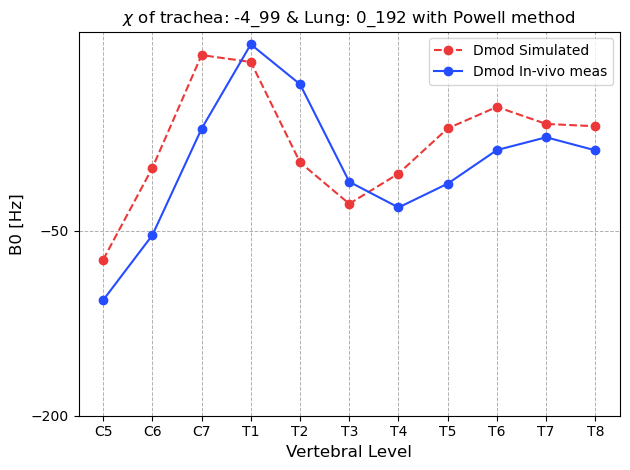

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #75
Chi for trachea: -4.99383154529386
Chi for lungs: 0.19234506921242456
For iteration #75 using -272.72493953365614
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_994_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_994_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_994_l_0_192_Hz.csv

Total runtime; 9.331 seconds.

Difference:  253.39294215577283


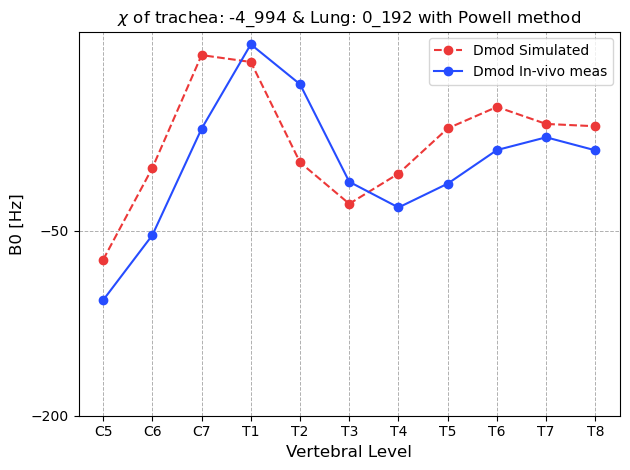

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #76
Chi for trachea: -4.996187685333542
Chi for lungs: 0.19234506921242456
For iteration #76 using -272.72513309945873
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_996_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_996_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_996_l_0_192_Hz.csv

Total runtime; 9.465 seconds.

Difference:  253.39029029188885


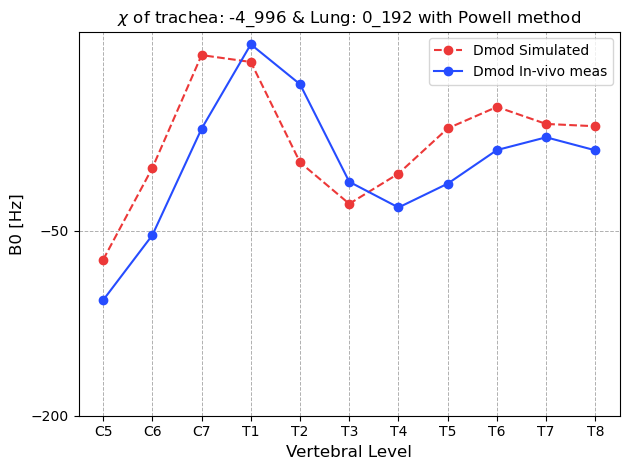

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #77
Chi for trachea: -4.997643859960319
Chi for lungs: 0.19234506921242456
For iteration #77 using -272.72525272970387
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_998_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_998_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_998_l_0_192_Hz.csv

Total runtime; 9.453 seconds.

Difference:  253.388651393263


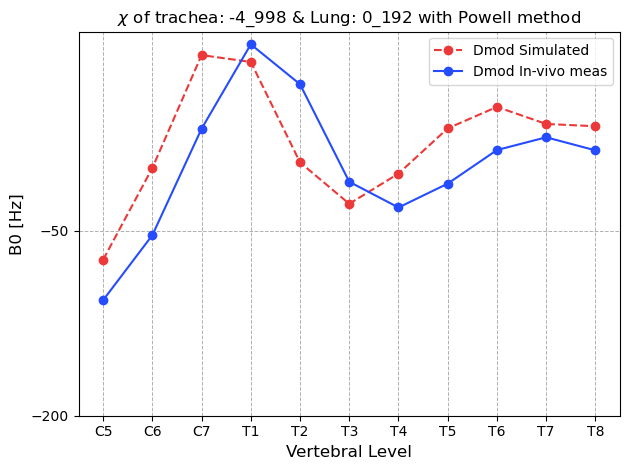

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #78
Chi for trachea: -4.998543825373223
Chi for lungs: 0.19234506921242456
For iteration #78 using -272.72532666526143
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_999_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_192_Hz.csv

Total runtime; 9.259 seconds.

Difference:  253.38763851478117


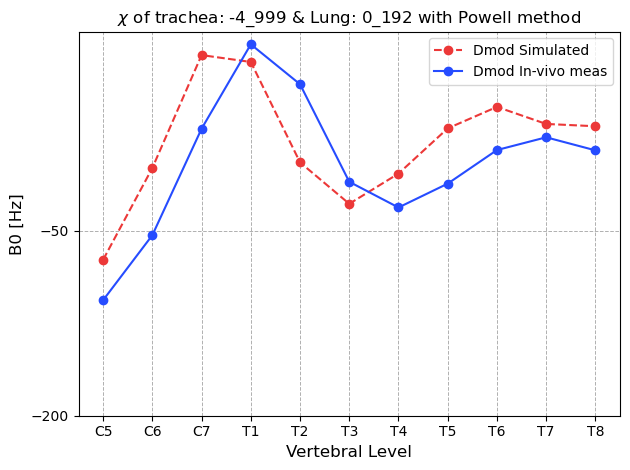

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #79
Chi for trachea: -4.999100034587096
Chi for lungs: 0.19234506921242456
For iteration #79 using -272.725372359949
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_999_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_192_Hz.csv

Total runtime; 9.244 seconds.

Difference:  253.38701252778344


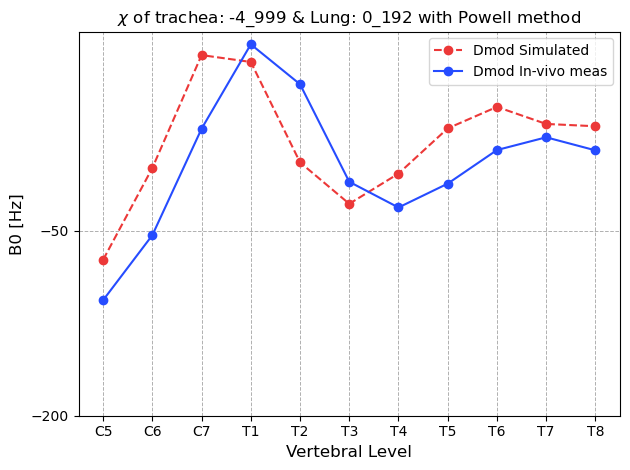

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #80
Chi for trachea: -4.999443790786126
Chi for lungs: 0.19234506921242456
For iteration #80 using -272.725400600819
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_999_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_192_Hz.csv

Total runtime; 9.338 seconds.

Difference:  253.3866256489603


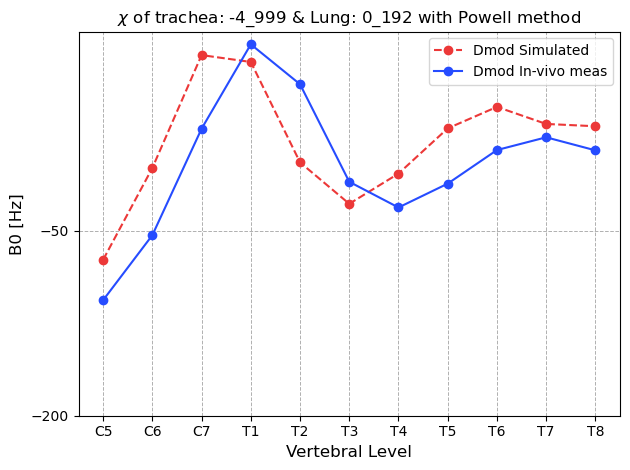

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #81
Chi for trachea: -4.99965624380097
Chi for lungs: 0.19234506921242456
For iteration #81 using -272.7254180546366
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.404 seconds.

Difference:  253.3863865456217


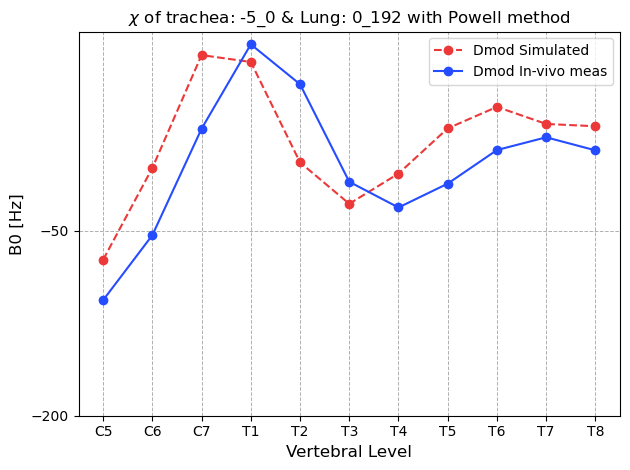

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #82
Chi for trachea: -4.999787546985156
Chi for lungs: 0.19234506921242456
For iteration #82 using -272.72542884168905
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.381 seconds.

Difference:  253.38623877198438


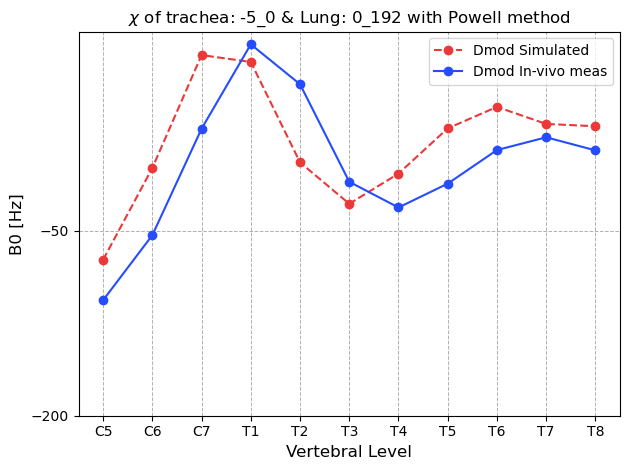

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #83
Chi for trachea: -4.999868696815814
Chi for lungs: 0.19234506921242456
For iteration #83 using -272.7254355084541
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.444 seconds.

Difference:  253.38614744298863


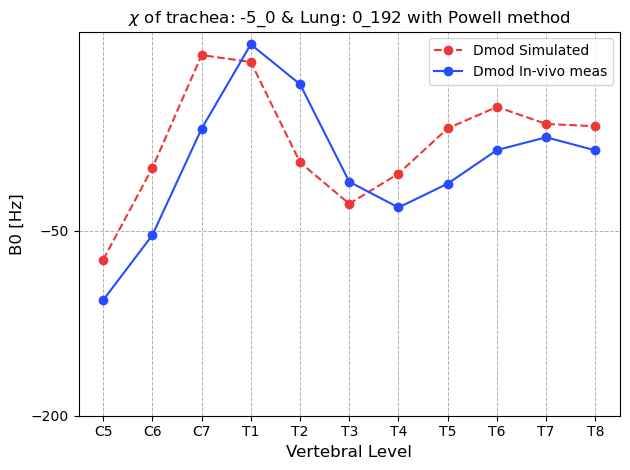

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #84
Chi for trachea: -4.999918850169342
Chi for lungs: 0.19234506921242456
For iteration #84 using -272.7254396287414
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.276 seconds.

Difference:  253.3860909986165


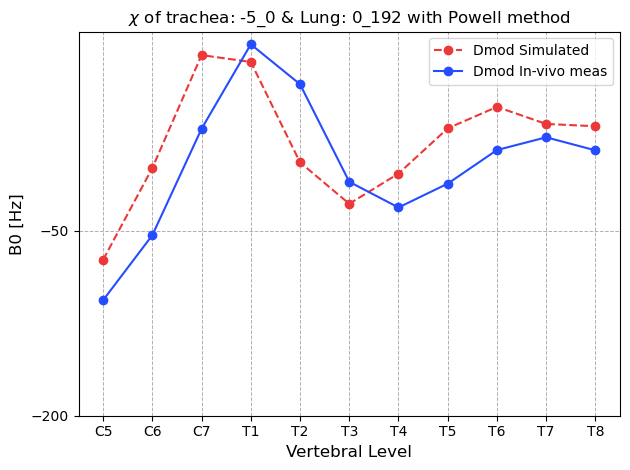

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #85
Chi for trachea: -4.999952183503466
Chi for lungs: 0.19234506921242456
For iteration #85 using -272.72544236720086
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.383 seconds.

Difference:  253.38605348411582


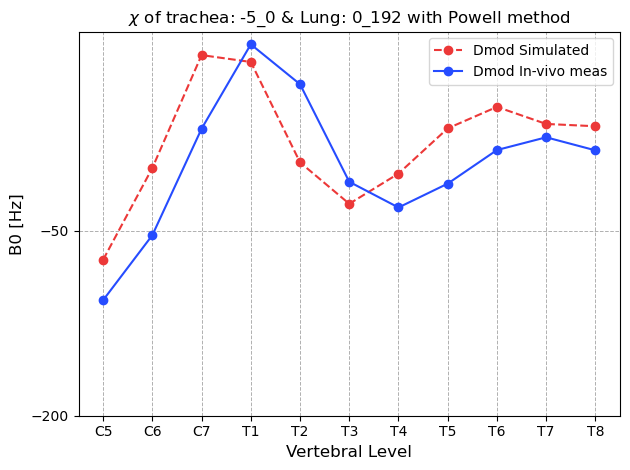

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #86
Chi for trachea: -3.64543620872042
Chi for lungs: -1.790910996120318
For iteration #86 using -267.65380427906416
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-3_645_l_-1_791_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-3_645_l_-1_791_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-3_645_l_-1_791_Hz.csv

Total runtime; 9.308 seconds.

Difference:  267.69568167532344


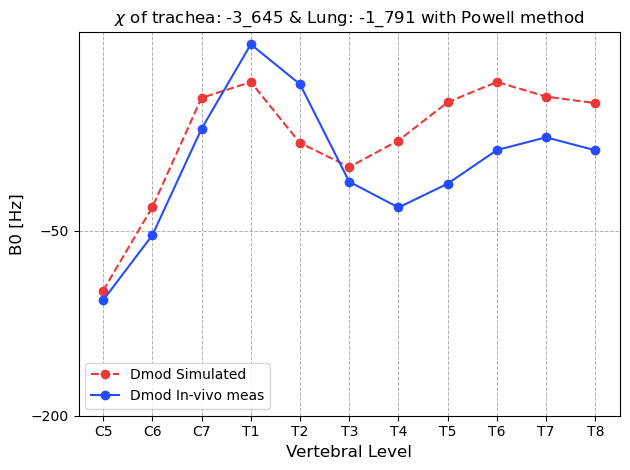

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #87
Chi for trachea: -2.8082697457797217
Chi for lungs: -3.016673922678813
For iteration #87 using -264.5192489112392
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-2_808_l_-3_017_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-2_808_l_-3_017_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-2_808_l_-3_017_Hz.csv

Total runtime; 9.229 seconds.

Difference:  288.0154433483392


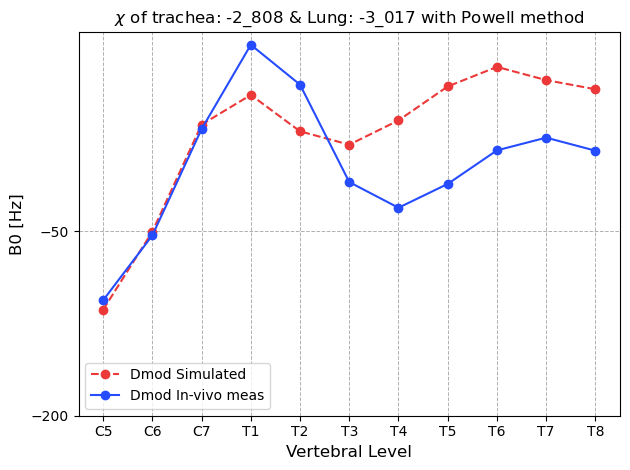

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #88
Chi for trachea: -4.162833537059301
Chi for lungs: -1.0333478453576266
For iteration #88 using -269.59106603599827
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_163_l_-1_033_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_163_l_-1_033_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_163_l_-1_033_Hz.csv

Total runtime; 9.358 seconds.

Difference:  259.2972692625755


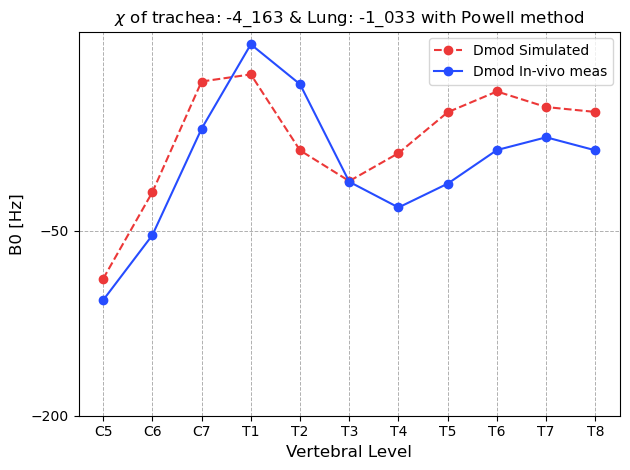

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #89
Chi for trachea: -4.482602671661119
Chi for lungs: -0.5651480695618227
For iteration #89 using -270.788359646889
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_483_l_-0_565_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_483_l_-0_565_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_483_l_-0_565_Hz.csv

Total runtime; 9.323 seconds.

Difference:  255.880499180724


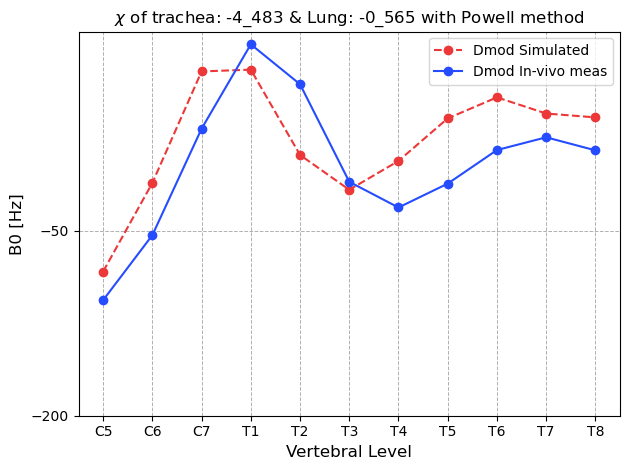

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #90
Chi for trachea: -4.680230865398182
Chi for lungs: -0.27578469459493554
For iteration #90 using -271.52832779293254
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_68_l_-0_276_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_68_l_-0_276_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_68_l_-0_276_Hz.csv

Total runtime; 9.193 seconds.

Difference:  254.4786830247297


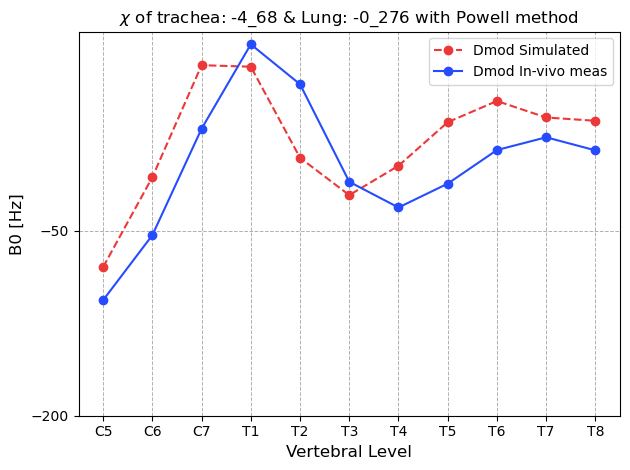

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #91
Chi for trachea: -4.802371806262936
Chi for lungs: -0.09694829376601877
For iteration #91 using -271.98565325777963
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_802_l_-0_097_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_802_l_-0_097_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_802_l_-0_097_Hz.csv

Total runtime; 9.430 seconds.

Difference:  253.88877014298728


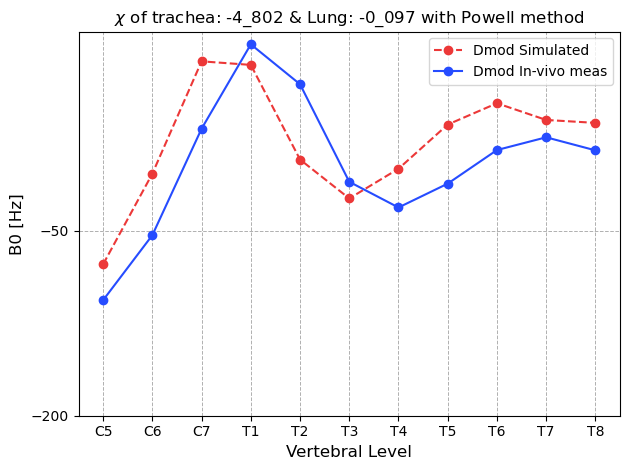

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #92
Chi for trachea: -4.877859059135246
Chi for lungs: 0.013578680371951701
For iteration #92 using -272.26829593897605
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_878_l_0_014_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_878_l_0_014_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_878_l_0_014_Hz.csv

Total runtime; 9.348 seconds.

Difference:  253.63064710095307


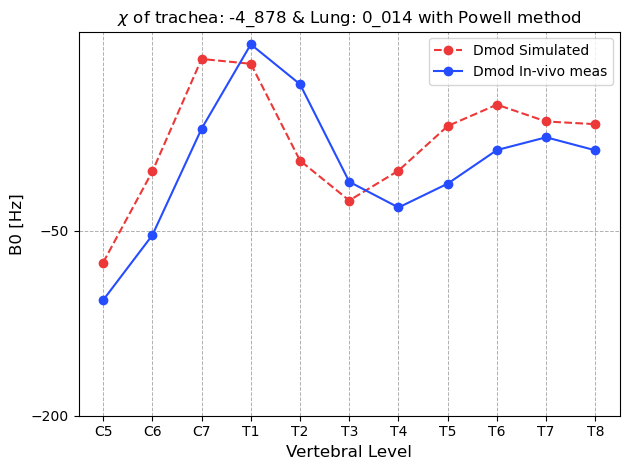

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #93
Chi for trachea: -4.924512747127691
Chi for lungs: 0.08188810706289805
For iteration #93 using -272.44297872262683
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_925_l_0_082_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_925_l_0_082_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_925_l_0_082_Hz.csv

Total runtime; 9.250 seconds.

Difference:  253.5119281436503


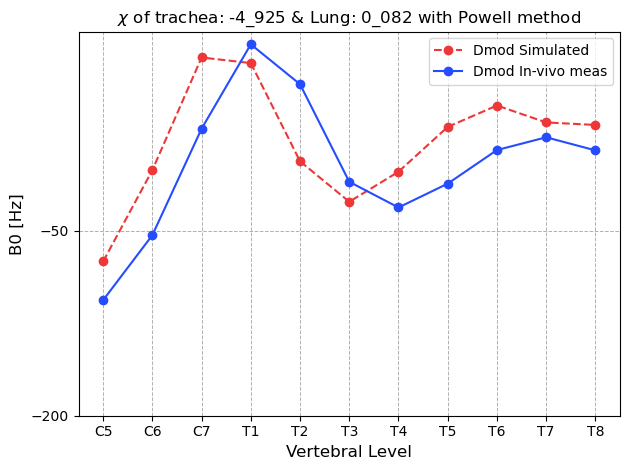

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #94
Chi for trachea: -4.953346312007555
Chi for lungs: 0.12410565450992217
For iteration #94 using -272.5509386201724
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_953_l_0_124_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_953_l_0_124_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_953_l_0_124_Hz.csv

Total runtime; 9.339 seconds.

Difference:  253.45416895008705


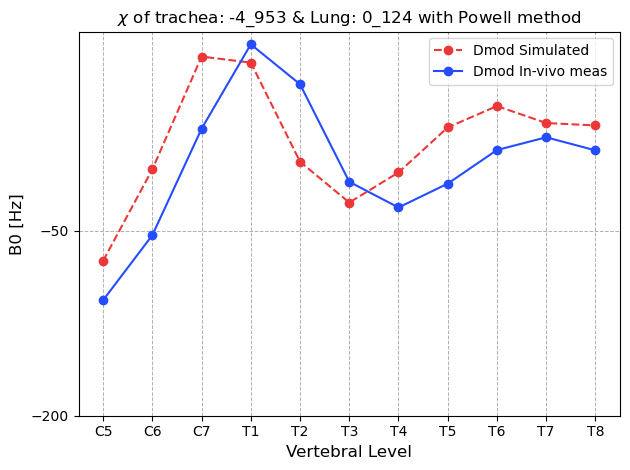

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #95
Chi for trachea: -4.971166435120136
Chi for lungs: 0.15019753375384443
For iteration #95 using -272.61766150627756
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_971_l_0_15_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_971_l_0_15_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_971_l_0_15_Hz.csv

Total runtime; 11.375 seconds.

Difference:  253.4244401262519


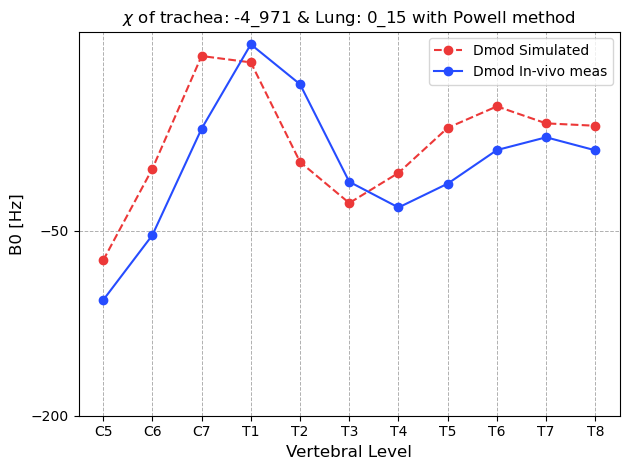

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #96
Chi for trachea: -4.982179876887419
Chi for lungs: 0.16632320195694628
For iteration #96 using -272.658898517718
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_982_l_0_166_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_982_l_0_166_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_982_l_0_166_Hz.csv

Total runtime; 11.182 seconds.

Difference:  253.40834729707527


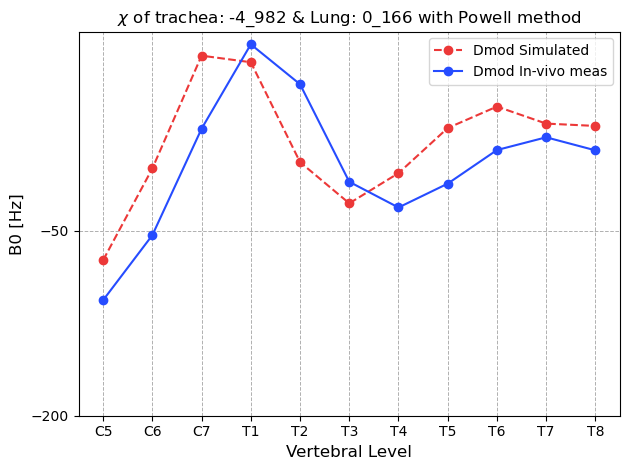

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #97
Chi for trachea: -4.9889865582327175
Chi for lungs: 0.17628941299776668
For iteration #97 using -272.6843843923827
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_989_l_0_176_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_989_l_0_176_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_989_l_0_176_Hz.csv

Total runtime; 11.257 seconds.

Difference:  253.39927267508668


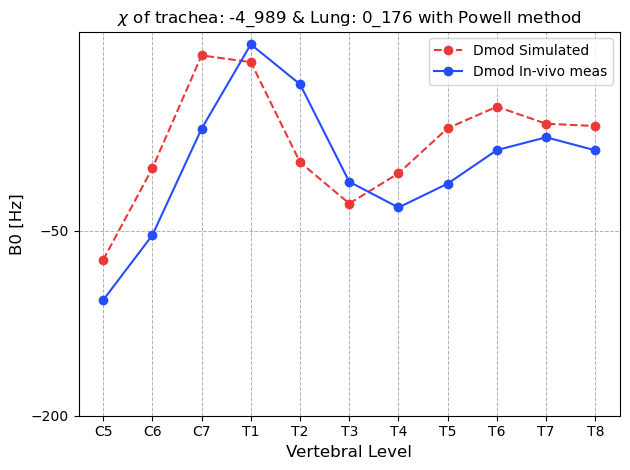

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #98
Chi for trachea: -4.9931933186547015
Chi for lungs: 0.18244887016004815
For iteration #98 using -272.70013552915856
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_993_l_0_182_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_993_l_0_182_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_993_l_0_182_Hz.csv

Total runtime; 11.406 seconds.

Difference:  253.39399709401053


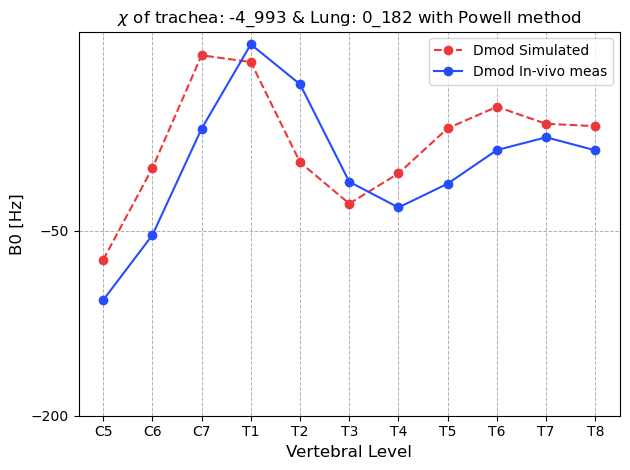

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #99
Chi for trachea: -4.995793239578016
Chi for lungs: 0.1862556240385871
For iteration #99 using -272.7098702670474
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_996_l_0_186_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_996_l_0_186_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_996_l_0_186_Hz.csv

Total runtime; 11.068 seconds.

Difference:  253.39086374926256


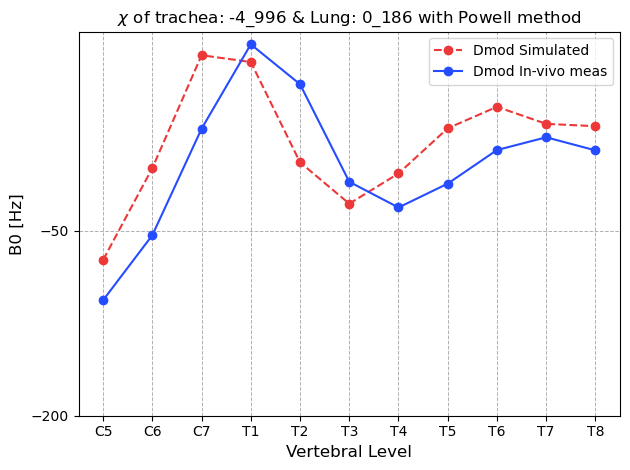

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #100
Chi for trachea: -4.9974000790766855
Chi for lungs: 0.18860832732232963
For iteration #100 using -272.71588666593425
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_997_l_0_189_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_997_l_0_189_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_997_l_0_189_Hz.csv

Total runtime; 11.240 seconds.

Difference:  253.3889758022279


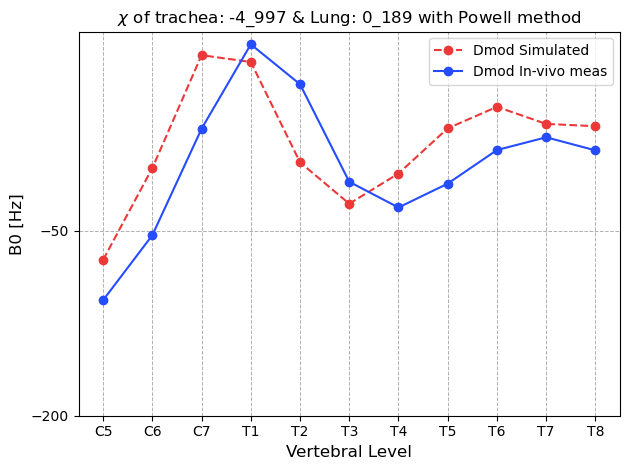

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #101
Chi for trachea: -4.99839316050133
Chi for lungs: 0.19006237791712602
For iteration #101 using -272.7196050049363
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_998_l_0_19_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_998_l_0_19_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_998_l_0_19_Hz.csv

Total runtime; 11.526 seconds.

Difference:  253.38782753800015


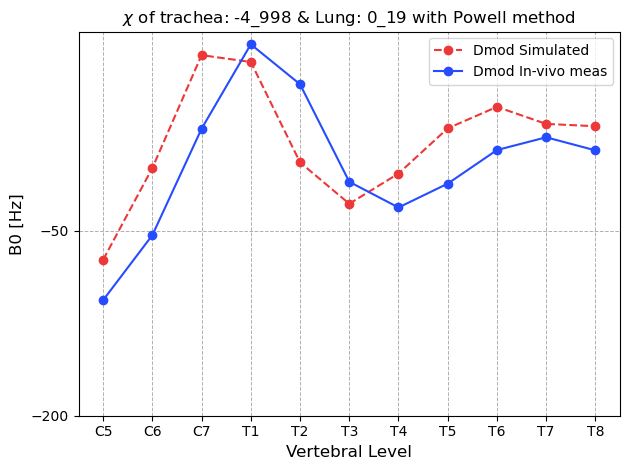

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #102
Chi for trachea: -4.999006918575356
Chi for lungs: 0.19096103060607217
For iteration #102 using -272.7219030648212
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_999_l_0_191_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_191_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_191_Hz.csv

Total runtime; 10.932 seconds.

Difference:  253.3871249577147


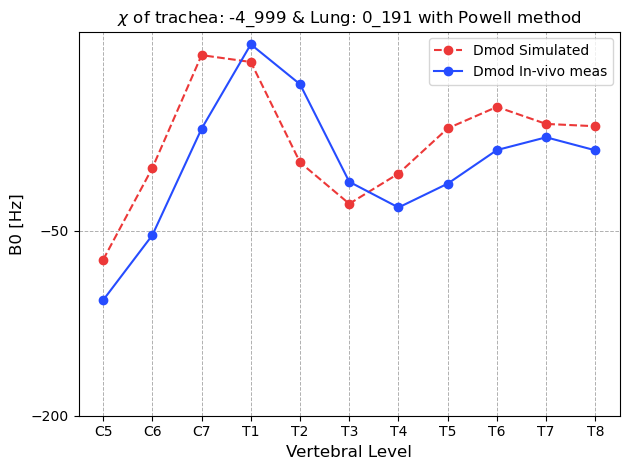

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #103
Chi for trachea: -4.999386241925974
Chi for lungs: 0.19151642851192238
For iteration #103 using -272.72332334393826
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-4_999_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-4_999_l_0_192_Hz.csv

Total runtime; 11.268 seconds.

Difference:  253.3866934458675


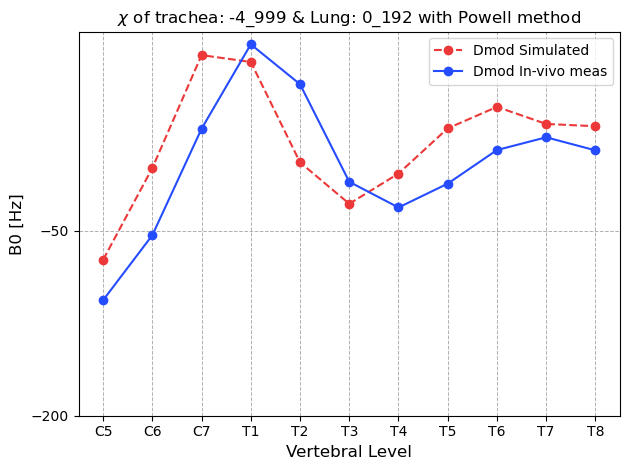

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #104
Chi for trachea: -4.999620676649382
Chi for lungs: 0.19185968329501835
For iteration #104 using -272.7242011247061
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.178 seconds.

Difference:  253.386427790733


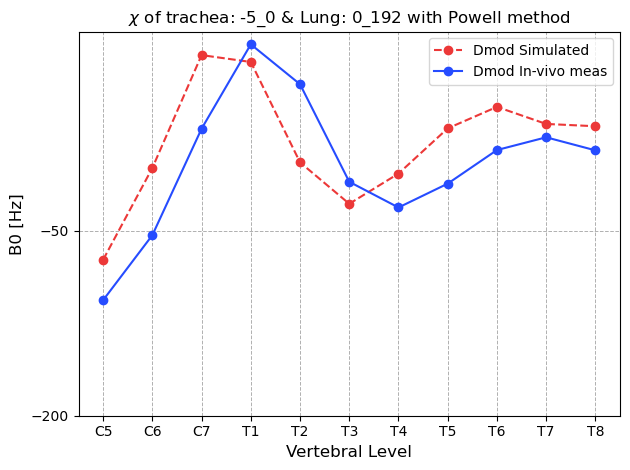

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #105
Chi for trachea: -4.999765565276592
Chi for lungs: 0.1920718264177726
For iteration #105 using -272.72474362305536
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.601 seconds.

Difference:  253.38626400172893


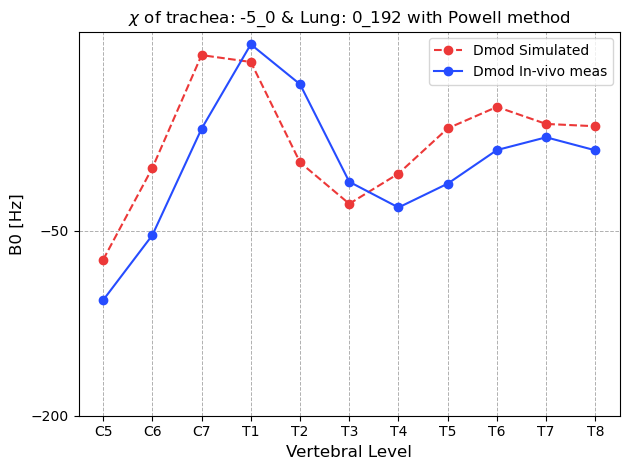

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #106
Chi for trachea: -4.99985511137279
Chi for lungs: 0.19220293807811428
For iteration #106 using -272.725078905474
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.201 seconds.

Difference:  253.38616292539547


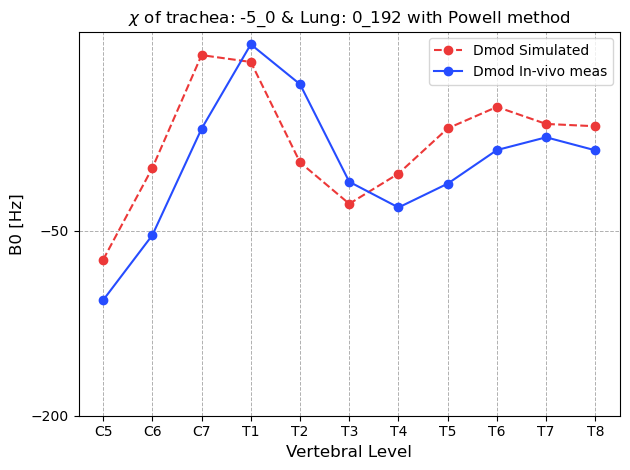

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #107
Chi for trachea: -4.9999104539038015
Chi for lungs: 0.19228396954052687
For iteration #107 using -272.7252861214045
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 10.901 seconds.

Difference:  253.3861005144009


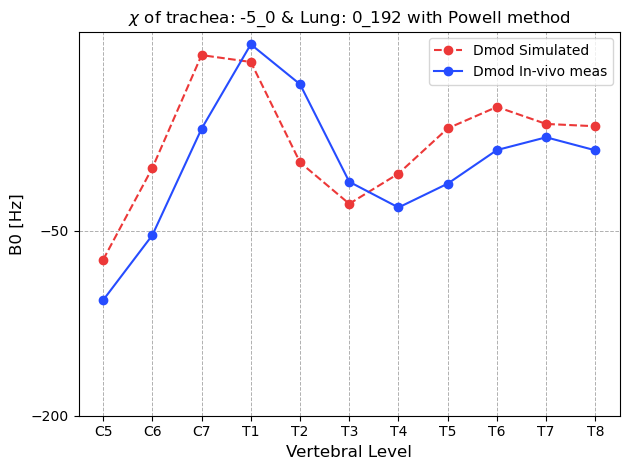

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #108
Chi for trachea: -4.99994465746899
Chi for lungs: 0.19233404973845597
For iteration #108 using -272.7254141878926
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.311 seconds.

Difference:  253.38606196429214


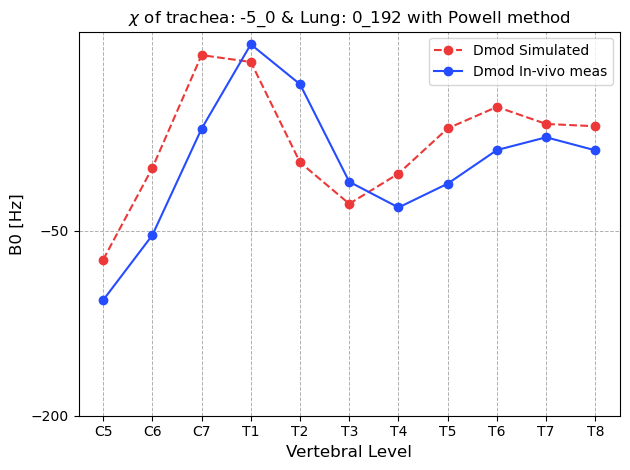

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #109
Chi for trachea: -4.999965796434812
Chi for lungs: 0.19236500100293946
For iteration #109 using -272.7254933373351
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.468 seconds.

Difference:  253.3860381474205


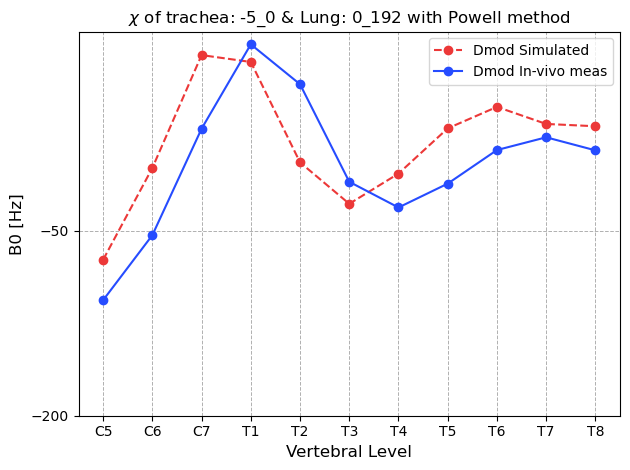

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #110
Chi for trachea: -4.999978861034178
Chi for lungs: 0.19238412993638504
For iteration #110 using -272.72554225438074
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.155 seconds.

Difference:  253.38602343099518


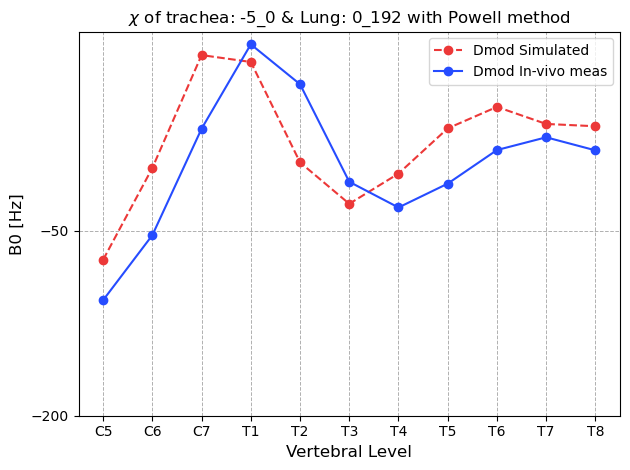

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #111
Chi for trachea: -4.999986935400635
Chi for lungs: 0.19239595226742295
For iteration #111 using -272.72557248677754
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.505 seconds.

Difference:  253.38601433697048


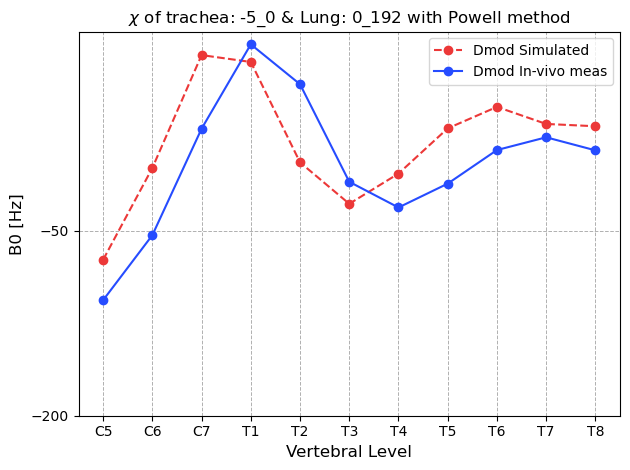

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #112
Chi for trachea: -4.999991925633543
Chi for lungs: 0.19240325886983065
For iteration #112 using -272.72559117142634
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 10.974 seconds.

Difference:  253.3860087170226


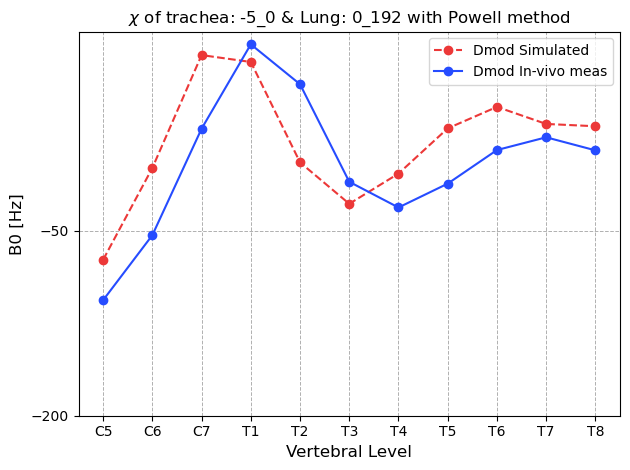

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #113
Chi for trachea: -4.999995009767092
Chi for lungs: 0.19240777459846087
For iteration #113 using -272.72560271917433
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 10.925 seconds.

Difference:  253.38600524388266


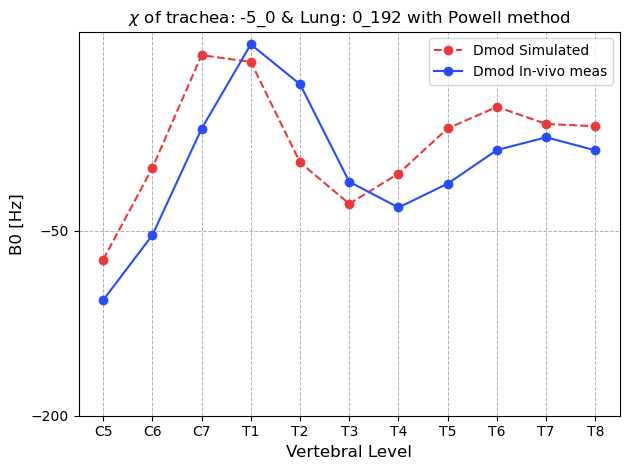

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #114
Chi for trachea: -4.999996915866451
Chi for lungs: 0.1924105654722383
For iteration #114 using -272.72560985607515
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.536 seconds.

Difference:  253.3860030974326


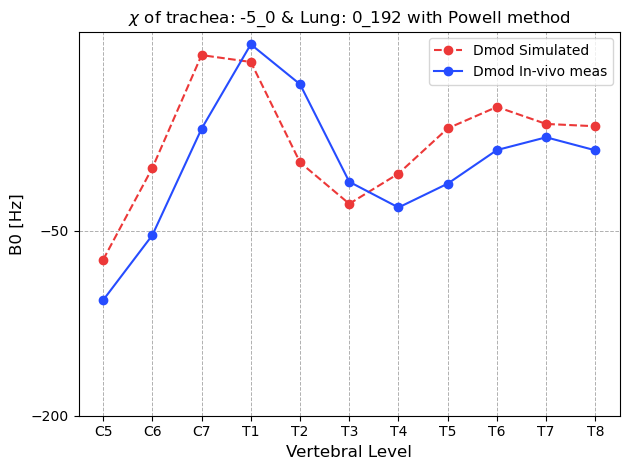

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #115
Chi for trachea: -4.999998093900641
Chi for lungs: 0.1924122903270911
For iteration #115 using -272.72561426692243
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.200 seconds.

Difference:  253.38600177087955


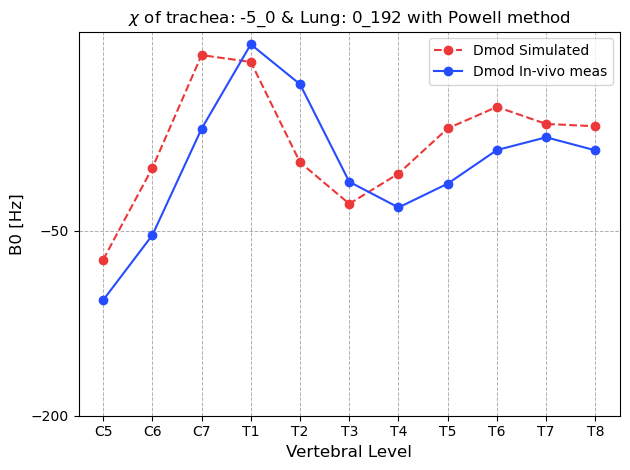

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #116
Chi for trachea: -4.99999882196581
Chi for lungs: 0.19241335634601578
For iteration #116 using -272.7256169929759
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.200 seconds.

Difference:  253.38600095103465


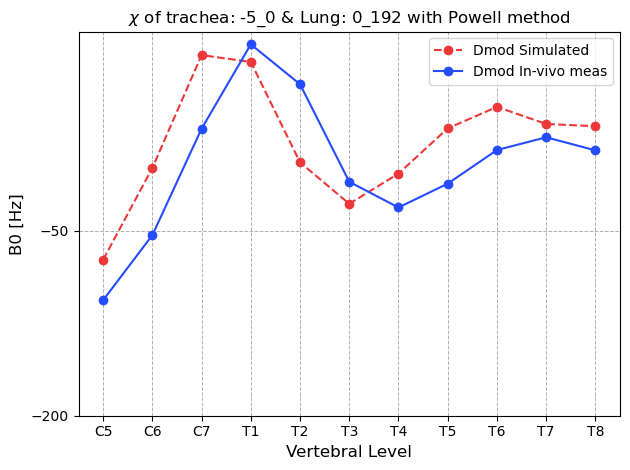

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #117
Chi for trachea: -4.999999271934831
Chi for lungs: 0.19241401518194387
For iteration #117 using -272.7256186777696
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.052 seconds.

Difference:  253.38600044434637


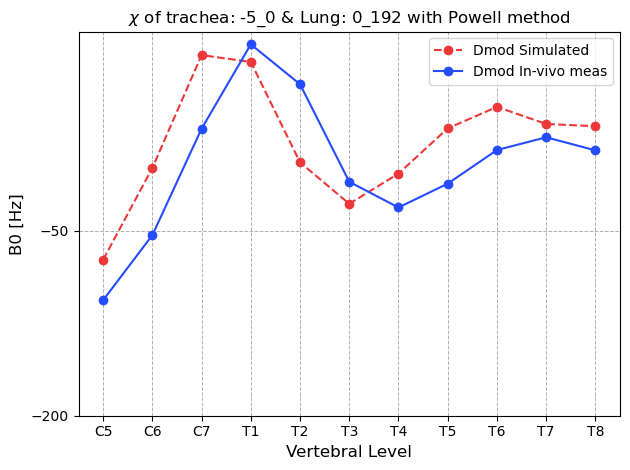

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #118
Chi for trachea: -4.99999955003098
Chi for lungs: 0.19241442236494044
For iteration #118 using -272.72561971902945
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.108 seconds.

Difference:  253.38600013119733


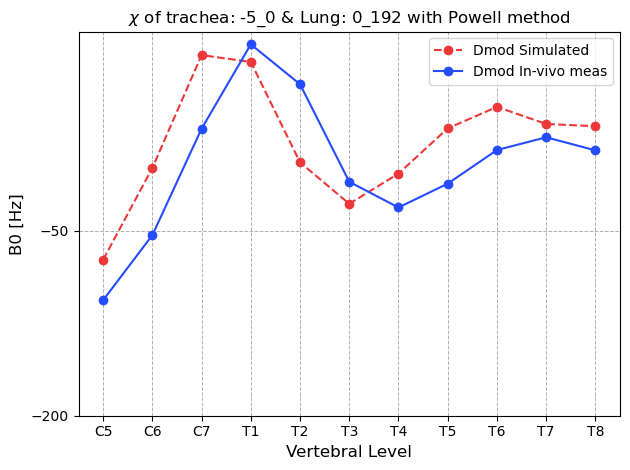

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #119
Chi for trachea: -4.999999721903851
Chi for lungs: 0.192414674017872
For iteration #119 using -272.7256203625634
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 11.167 seconds.

Difference:  253.38599993766118


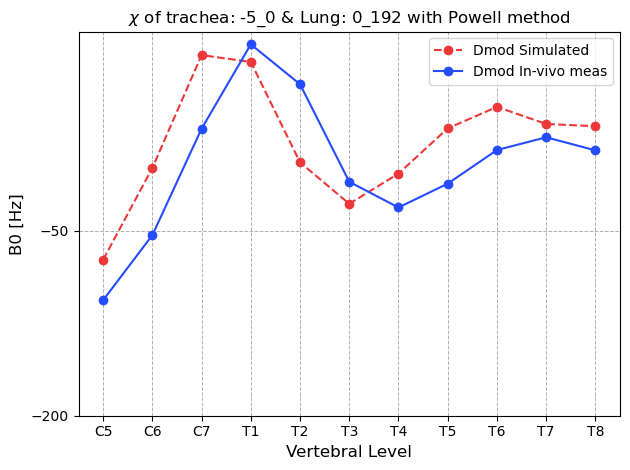

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #120
Chi for trachea: -4.999999828127128
Chi for lungs: 0.19241482954793704
For iteration #120 using -272.72562076028925
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.249 seconds.

Difference:  253.3859998180494


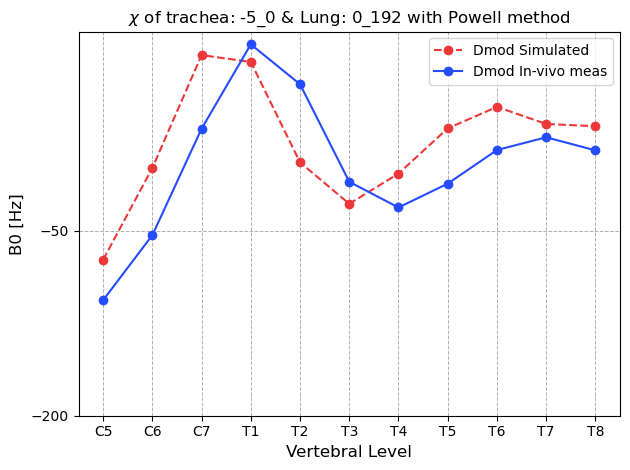

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #121
Chi for trachea: -4.999999893776724
Chi for lungs: 0.1924149256708035
For iteration #121 using -272.72562100609736
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.347 seconds.

Difference:  253.38599974412534


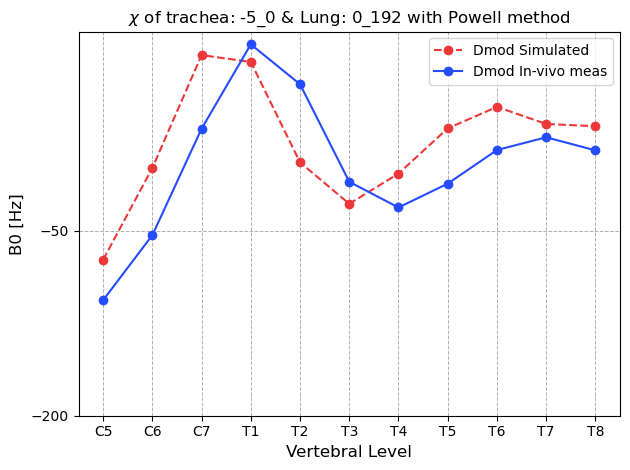

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #122
Chi for trachea: -4.999999934350405
Chi for lungs: 0.1924149850780021
For iteration #122 using -272.7256211580151
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.509 seconds.

Difference:  253.38599969843781


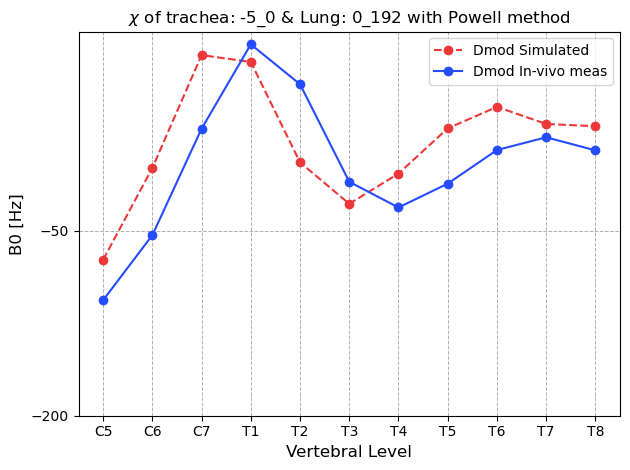

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #123
Chi for trachea: -4.999999959426319
Chi for lungs: 0.19241502179366998
For iteration #123 using -272.7256212519054
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.377 seconds.

Difference:  253.3859996702014


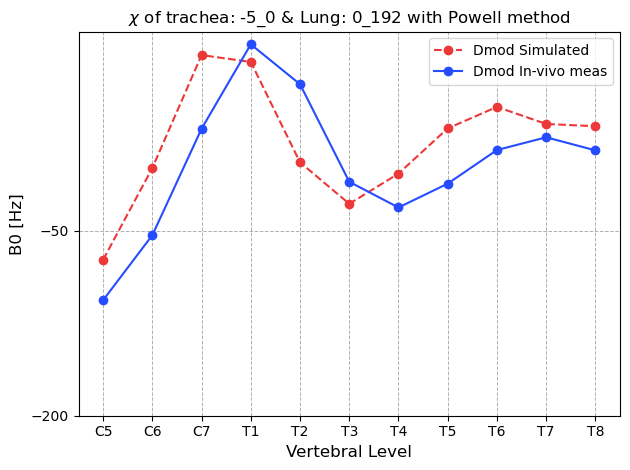

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #124
Chi for trachea: -4.999999974924086
Chi for lungs: 0.19241504448520066
For iteration #124 using -272.7256213099328
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.318 seconds.

Difference:  253.3859996527503


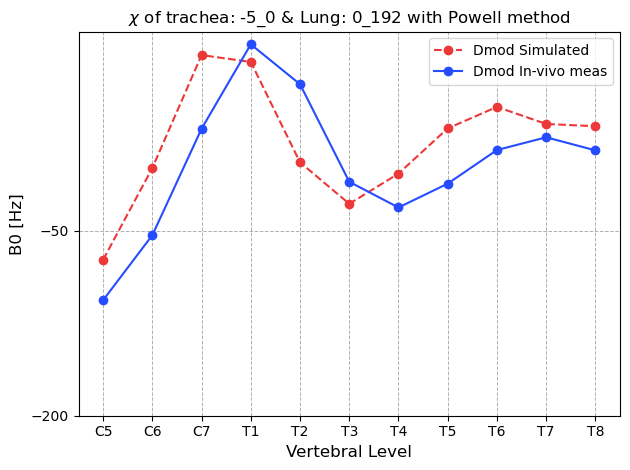

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #125
Chi for trachea: -4.9999999845022325
Chi for lungs: 0.19241505850933788
For iteration #125 using -272.72562134579573
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.276 seconds.

Difference:  253.38599964196496


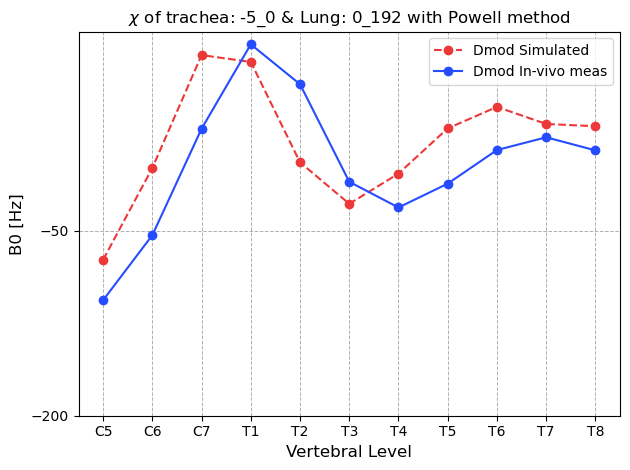

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #126
Chi for trachea: -4.999999990421853
Chi for lungs: 0.19241506717673135
For iteration #126 using -272.72562136796023
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.212 seconds.

Difference:  253.3859996352992


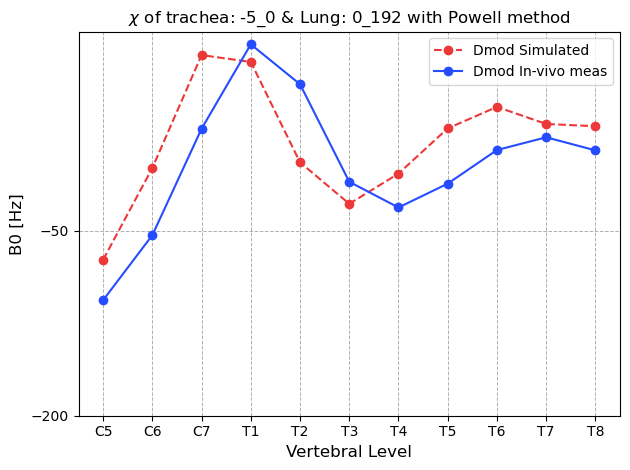

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #127
Chi for trachea: -4.99999999408038
Chi for lungs: 0.1924150725334751
For iteration #127 using -272.7256213816587
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.252 seconds.

Difference:  253.3859996311796


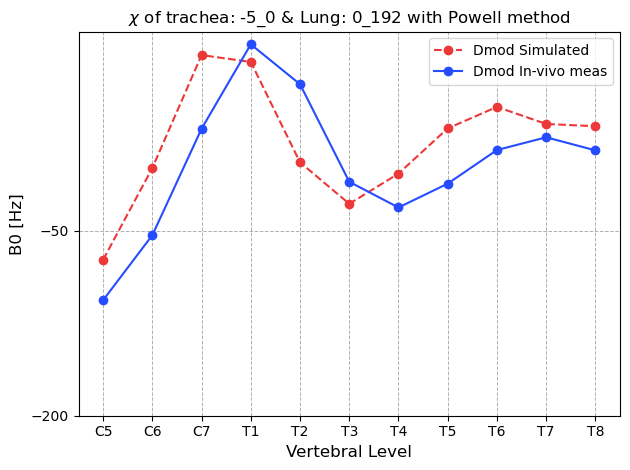

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #128
Chi for trachea: -4.99999999697009
Chi for lungs: 0.19241507676453315
For iteration #128 using -272.72562139247844
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_fms\test2_fixnan\sim_dmod_fm_tr_-5_0_l_0_192_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\iter_metrics\test2_fixnan\metrics_sim_dmod_fm_tr_-5_0_l_0_192_Hz.csv

Total runtime; 9.383 seconds.

Difference:  253.38599962792566


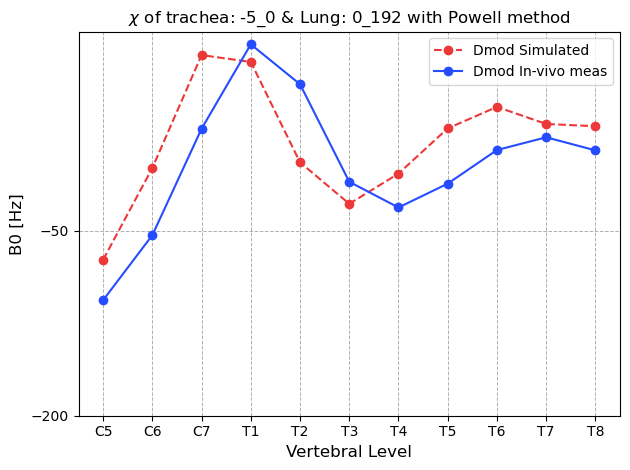

Optimization result:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 253.38599962792566
       x: [-5.000e+00  1.924e-01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00]
           [ 8.667e-05 -1.269e-04]]
    nfev: 128
######## ############## ############### #############


In [44]:
# Set initial values, boundaries and run optimization
initial_values = [-2, -4.2] # Body should begin
# First bound is trachea // Depends on objective code !!!
# Second bound is Lung // Depends on objective code !!!
# Check the MD above!
bounds = [(-5, 0.2), (-5, 0.2)]

if counter != 0 :
        # This means that you forgot to change the folder run number, to avoid mixing tests, please run that cell 
        # Changing the number after run!
    print("Please change run # to avoid mixing result folders :)")
else:
    if not os.path.exists(path_to_iter_fms) or not os.path.exists(path_to_iter_metrics):
        print("Creating run folders")
        os.makedirs(path_to_iter_fms)
        os.makedirs(path_to_iter_metrics)
        print("Folders created: ", path_to_iter_fms)
    
    result = optimize.minimize(f_simple_double_opt, initial_values, bounds = bounds, method = 'Powell')

    # Output the result
    print("Optimization result:", result)
    print("######## ############## ############### #############")

<Figure size 640x480 with 0 Axes>

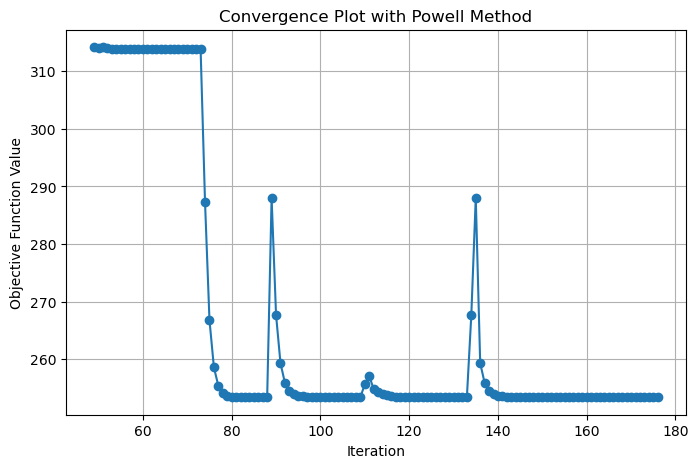

In [59]:
plt.figure()
chi_values_range = np.linspace(-1, 0.5, 100)

plt.figure(figsize=(8, 5))
plt.plot(history, marker='o', linestyle='-')

plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence Plot with Powell Method")
plt.grid()
plt.show()

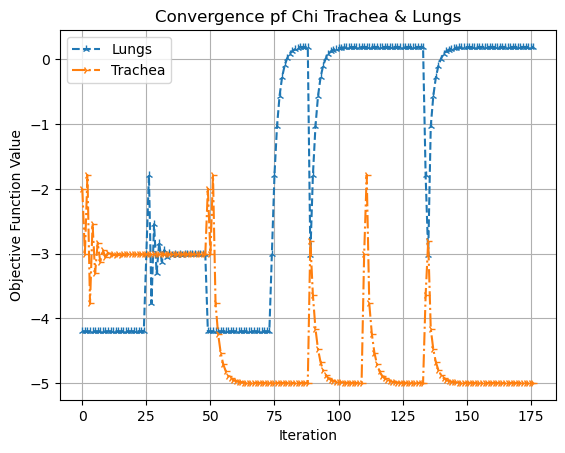

In [56]:
plt.figure()
chi_values_range = np.linspace(-1, 0.5, 100)
plt.plot(history_chi_lungs, marker='2', linestyle='--')
plt.plot(history_chi_trachea, marker='4', linestyle='-.')

plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence pf Chi Trachea & Lungs")
plt.legend(["Lungs", "Trachea"])
plt.grid()
plt.show()

 # <span style="color:#D8C40D6A"> *Metrics!* </span> </br>
 Let's analyze how much we've improved after optimization

In [57]:
worst_l2 = np.max(history)
print("Worst L2 norm: ", worst_l2)
best_l2 = np.min(history)
print("Best L2 norm: ", best_l2)

Worst L2 norm:  nan
Best L2 norm:  nan
